In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift

warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

## Load Polygons and plot totals

In [3]:
ac_mcclure = gpd.read_file("/data2/lthapa/ML_daily/August_Complex_2020/August_Complex_2020/MODIS_perdetect_growthonly_August_2020.shp")
ac_mcclure # TIME IS IN UTC

,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn,geometry
0,2020_690,2020-08-17 01:30:00,MYD,445.600007,8,1.576021e+03,1,"MULTIPOLYGON (((-122.78349 39.68307, -122.7837..."
1,2020_690,2020-08-17 22:30:00,MOD,7637.300115,44,7.251640e+03,1,"MULTIPOLYGON (((-122.81597 39.68307, -122.8162..."
2,2020_690,2020-08-18 10:30:00,MOD,1682.200025,24,3.937226e+03,1,"MULTIPOLYGON (((-122.85415 39.64974, -122.8544..."
3,2020_690,2020-08-19 10:30:00,MOD,41881.500628,125,2.373187e+04,1,"MULTIPOLYGON (((-122.95248 39.52745, -122.9525..."
4,2020_690,2020-08-19 13:30:00,MYD,104777.801572,173,2.858680e+04,1,"MULTIPOLYGON (((-122.76536 39.50806, -122.7655..."
...,...,...,...,...,...,...,...,...
197,2020_690,2020-10-16 10:30:00,MOD,46.000001,4,1.315000e-12,1,"POLYGON ((-123.09575 40.26074, -123.09577 40.2..."
198,2020_690,2020-10-16 13:30:00,MYD,217.400003,9,1.890519e+02,1,"MULTIPOLYGON (((-123.09155 40.25593, -123.0915..."
199,2020_690,2020-10-16 22:30:00,MOD,353.200005,8,1.890624e+02,1,"MULTIPOLYGON (((-123.43953 40.18578, -123.4396..."
200,2020_690,2020-10-17 13:30:00,MYD,277.800004,6,3.290000e-13,1,"POLYGON ((-123.10245 40.25245, -123.10255 40.2..."


In [4]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('august_complex_polygons_only_MODIS.geojson') #polygons only
fire_attributes = pd.read_csv('august_complex_polygons_attributes_MODIS.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];
print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa_att))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, pd.DataFrame({'DateTim':datestrings}), ac_thapa_poly], axis=1))
ac_thapa

<class 'numpy.ndarray'>


,Unnamed: 0,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of MODIS points,FRP,DateTim,geometry
0,0,11843929.0,AUGUST COMPLEX,2020-08-18,427.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0427,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
1,1,11843929.0,AUGUST COMPLEX,2020-08-18,429.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0429,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
2,2,11843929.0,AUGUST COMPLEX,2020-08-18,430.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0430,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
3,3,11843929.0,AUGUST COMPLEX,2020-08-18,431.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0431,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
4,4,11843929.0,AUGUST COMPLEX,2020-08-18,605.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0605,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
...,...,...,...,...,...,...,...,...,...,...,...
1915,1915,11843929.0,AUGUST COMPLEX,2020-11-11,2004.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2004,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1916,1916,11843929.0,AUGUST COMPLEX,2020-11-11,2142.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2142,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1917,1917,11843929.0,AUGUST COMPLEX,2020-11-11,2143.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2143,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1918,1918,11843929.0,AUGUST COMPLEX,2020-11-11,2144.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2144,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."


## Old version of plot all polygons

In [ ]:
ac_mcclure.plot(column = ac_mcclure['DateTim'])
plt.title('McClure')
plt.show()

ac_thapa_poly.plot()
plt.title('Thapa')
plt.show()

## New Version of plot all polygons (4/1/2022)
More red is later on, uses the per overpass version of my polygons


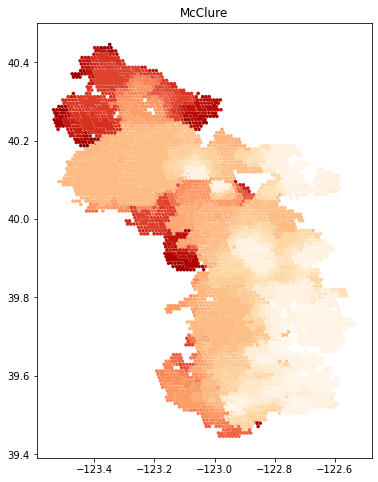

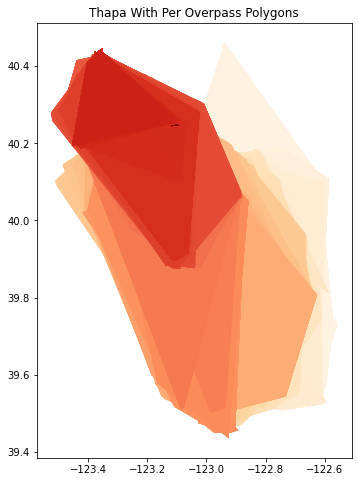

In [5]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_mcclure.plot(column = ac_mcclure['DateTim'], ax=ax, cmap='OrRd')
plt.title('McClure')
plt.show()

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_thapa.plot(column = ac_thapa['DateTim'], ax=ax, cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

## Plot Daily AC

In [ ]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('fire_polygons_only.geojson') #polygons only
fire_attributes = pd.read_csv('fire_polygons_attributes.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

#datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
#               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, ac_thapa_poly], axis=1))
ac_thapa

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_thapa.plot(column = ac_thapa['Current Day'], ax=ax, cmap='OrRd')
plt.title('Thapa With Daily Polygons')
plt.show()

## Generate time series

In [ ]:
#combine into daily polygons, originally we did this by sum, but that double counts

days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='sum',as_index=False)
ac_mcclure_daily

In [6]:
#average over the overpasses to avoid double counting
days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='max',as_index=False)
ac_mcclure_daily

,Days,geometry,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn
0,2020-08-17,"MULTIPOLYGON (((-122.81597 39.68307, -122.8162...",2020_690,2020-08-17 22:30:00,MYD,7637.300115,44,7.251640e+03,1
1,2020-08-18,"MULTIPOLYGON (((-122.85415 39.64974, -122.8544...",2020_690,2020-08-18 10:30:00,MOD,1682.200025,24,3.937226e+03,1
2,2020-08-19,"MULTIPOLYGON (((-122.96370 39.51640, -122.9639...",2020_690,2020-08-19 22:30:00,MYD,118349.701775,173,2.968140e+04,1
3,2020-08-20,"MULTIPOLYGON (((-122.65388 39.53922, -122.6537...",2020_690,2020-08-20 22:30:00,MYD,51971.500780,353,3.341888e+04,1
4,2020-08-21,"MULTIPOLYGON (((-122.74720 39.52744, -122.7473...",2020_690,2020-08-21 22:30:00,MYD,20747.000311,247,1.347529e+04,1
...,...,...,...,...,...,...,...,...,...
56,2020-10-14,"POLYGON ((-123.39349 40.20245, -123.39359 40.2...",2020_690,2020-10-14 13:30:00,MYD,175.100003,6,1.841330e+02,1
57,2020-10-15,"MULTIPOLYGON (((-123.40024 40.19395, -123.4001...",2020_690,2020-10-15 13:30:00,MYD,3648.200055,50,7.353029e+02,1
58,2020-10-16,"MULTIPOLYGON (((-123.42871 40.18561, -123.4288...",2020_690,2020-10-16 22:30:00,MYD,353.200005,9,5.718499e+02,1
59,2020-10-17,"POLYGON ((-123.10245 40.25245, -123.10255 40.2...",2020_690,2020-10-17 13:30:00,MYD,277.800004,6,3.290000e-13,1


In [7]:
ac_thapa_daily = ac_thapa.dissolve(by='Current Day', aggfunc='max',as_index=False)
ac_thapa_daily

,Current Day,geometry,Unnamed: 0,Incident Number,Fire Name,Current Overpass,Lat Fire,Lon Fire,Number of MODIS points,FRP,DateTim
0,2020-08-18,"POLYGON ((-122.76889 39.65944, -122.76908 39.6...",24,11843929.0,AUGUST COMPLEX,1949.0,39.659444,-122.808889,6.0,393.3,2020-08-18 1949
1,2020-08-19,"POLYGON ((-122.94010 39.52861, -122.94840 39.5...",49,11843929.0,AUGUST COMPLEX,2033.0,39.659444,-122.808889,69.0,36257.0,2020-08-19 2033
2,2020-08-20,"POLYGON ((-122.73990 39.51040, -122.79182 39.5...",73,11843929.0,AUGUST COMPLEX,2115.0,39.659444,-122.808889,267.0,38618.5,2020-08-20 2115
3,2020-08-21,"POLYGON ((-122.61233 40.10838, -122.59470 40.1...",94,11843929.0,AUGUST COMPLEX,2020.0,39.659444,-122.808889,140.0,8138.9,2020-08-21 2020
4,2020-08-22,"POLYGON ((-122.92140 39.50740, -122.92272 39.5...",124,11843929.0,AUGUST COMPLEX,2103.0,39.659444,-122.808889,113.0,7312.1,2020-08-22 2103
...,...,...,...,...,...,...,...,...,...,...,...
81,2020-11-07,"POLYGON ((-123.11670 40.24470, -123.09930 40.2...",1870,11843929.0,AUGUST COMPLEX,2211.0,39.659444,-122.808889,0.0,NaN,2020-11-07 2211
82,2020-11-08,"POLYGON ((-123.11670 40.24470, -123.09930 40.2...",1883,11843929.0,AUGUST COMPLEX,2115.0,39.659444,-122.808889,0.0,NaN,2020-11-08 2115
83,2020-11-09,"POLYGON ((-123.11670 40.24470, -123.09930 40.2...",1892,11843929.0,AUGUST COMPLEX,2020.0,39.659444,-122.808889,0.0,NaN,2020-11-09 2020
84,2020-11-10,"POLYGON ((-123.11670 40.24470, -123.09930 40.2...",1906,11843929.0,AUGUST COMPLEX,2103.0,39.659444,-122.808889,0.0,NaN,2020-11-10 2103


In [8]:
#get the days that are covered by both time series (stored in times)
times_mcclure = np.arange(np.datetime64(ac_mcclure_daily['Days'].iloc[0]),\
                          np.datetime64(ac_mcclure_daily['Days'].iloc[len(ac_mcclure_daily)-1])+np.timedelta64(1,'D'))
times_thapa = np.arange(np.datetime64(ac_thapa_daily['Current Day'].iloc[0]),\
                          np.datetime64(ac_thapa_daily['Current Day'].iloc[len(ac_thapa_daily)-1])+np.timedelta64(1,'D'))
times, c1, c2 = np.intersect1d(times_mcclure, times_thapa, return_indices=True)

print(times)

#c1
#The indices of the first occurrences of the common values in times_mcclure. Only provided if return_indices is True.

#c2
#The indices of the first occurrences of the common values in times_thapa. Only provided if return_indices is True.


['2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21' '2020-08-22'
 '2020-08-23' '2020-08-24' '2020-08-25' '2020-08-26' '2020-08-27'
 '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31' '2020-09-01'
 '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05' '2020-09-06'
 '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10' '2020-09-11'
 '2020-09-12' '2020-09-13' '2020-09-14' '2020-09-15' '2020-09-16'
 '2020-09-17' '2020-09-18' '2020-09-19' '2020-09-20' '2020-09-21'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' '2020-10-05' '2020-10-06'
 '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-10' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18']


In [ ]:
print(ac_mcclure['pixels'].values)
#print(ac_thapa['Number of VIIRS points'].values)

### MERRA Time Series

In [19]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))
wind =  np.zeros((2, len(times)))


varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        wind[0,ii]= np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        temp[1,ii] = np.max(feature_hourly(T, overlap_thapa))
        vpd[1,ii] = np.max(feature_hourly(VPD, overlap_thapa))
        wind[1,ii]= np.max(feature_hourly(W, overlap_thapa))
        num_points[1,ii] = ac_thapa_daily['Number of MODIS points'].iloc[thapa_ind[0]]
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        wind[1,ii]= np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        temp[0,ii] = np.max(feature_hourly(T, overlap_mcclure))
        vpd[0,ii] = np.max(feature_hourly(VPD, overlap_mcclure))
        wind[0,ii]= np.max(feature_hourly(W, overlap_mcclure))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        temp[0,ii] = np.max(feature_hourly(T, overlap_mcclure))
        vpd[0,ii] = np.max(feature_hourly(VPD, overlap_mcclure))
        wind[0,ii]= np.max(feature_hourly(W, overlap_mcclure))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        temp[1,ii] = np.max(feature_hourly(T, overlap_thapa))
        vpd[1,ii] = np.max(feature_hourly(VPD, overlap_thapa))
        wind[1,ii]= np.max(feature_hourly(W, overlap_thapa))
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        num_points[1,ii] = ac_thapa_daily['Number of MODIS points'].iloc[thapa_ind[0]]
    

0
(24, 37, 39)
0 both polys
-123.86104360412675 38.6329986345256 -121.64416731525488 40.760162810003514
2 5 15 20
-123.84768435620518 38.620648943794826 -121.6637464179888 40.75626583920893
2 5 15 20
1
(24, 37, 39)
1 both polys
-123.9705307149124 38.4996652234853 -121.52782110883946 41.150334290803826
2 6 15 20
-123.94783977385062 38.51103714565245 -121.55800000154481 40.90505460513589
2 6 15 20
2
(24, 37, 39)
2 both polys
-124.0966405687717 38.50799852802305 -121.56873043816617 41.19200094269021
1 5 15 20
-124.08547409474099 38.51103714565245 -121.55800000154481 41.44819035782604
1 6 15 21
3
(24, 37, 39)
3 both polys
-123.95289887987717 38.50845142955713 -121.57957689380376 41.192000951629474
2 5 15 20
-124.08547409474099 38.51119276471477 -121.57549508606508 41.45982546657748
1 5 15 21
4
(24, 37, 39)
4 both polys
-124.10082825188753 38.49966518740157 -121.58369913063997 41.17532482077531
1 5 15 20
-124.08990840737533 38.50850259313198 -121.58572764629044 41.1895195898106
1 5 15 20
5


-124.51069544803492 38.95799884723387 -121.92032010229397 41.425325370619625
1 5 16 21
-124.49396560481493 38.514036061867216 -121.8910371560741 41.41884419497467
1 5 15 21
43
(24, 37, 39)
43 both polys
-124.49315410526224 38.95799884421224 -122.10899549820111 41.400325295606265
1 5 16 21
-124.48494924545324 38.877291659574375 -121.88691340410003 41.41979205507293
1 5 16 21
44
(24, 37, 39)
44 both polys
-124.48491123934572 38.95799884366133 -122.09091664550753 41.40210076613588
1 5 16 21
-124.4840239074979 38.876923119504035 -121.8968537604937 41.420666128858734
1 5 16 21
45
(24, 37, 39)
45 both polys
-124.50674398866863 38.90799880780184 -121.87895444137823 41.42532543163786
1 5 16 21
-124.47902858658387 38.956381070456914 -121.89185999774494 41.421866132545546
1 5 16 21
46
(24, 37, 39)
46 both polys
-124.48268623834208 38.91633214602323 -121.88310118612914 41.44199194336193
1 5 16 21
-124.4909414063428 38.9222832336315 -121.87717382395972 41.426805755335785
1 5 16 21
47
(24, 37, 39)


In [ ]:
#print(temp, vpd, frp)
print(num_points)
#print(frp)
#print(len(wind[0,:]))

### FCCS Time Series

In [ ]:
varis = {'/static_maps/static_map_1km.nc4': ['fccs', 'slp', 'asp']}
#0=lat, 1=lon, 2=time, 3=level 
dims = {'/static_maps/static_map_1km.nc4': ['lat', 'lon']}

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
fuels = np.zeros((2, len(times)))
slopes = np.zeros((2, len(times)))
aspects = np.zeros((2, len(times)))

# load in the FCCS Data
path = '../static_maps/static_map_1km.nc4'
dat = nc.Dataset(path)  

lat = dat['lat'][:]
lon = dat['lon'][:]
fccs = dat['fccs'][:]
slp = dat['slp'][:]
asp = dat['asp'][:]

if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat) 
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)


for ii in range(len(times)):
    print(ii)
    
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    print(mcclure_ind)
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        fuels[0,ii] = np.nan
        slopes[0,ii] = np.nan
        aspects[0,ii] = np.nan
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05)) #0.05 degree buffer to check fuels 
        fuels[1,ii] = find_mode(fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        slopes[1,ii] = np.nanmax(slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        aspects[1,ii] = find_mode(asp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
    
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        fuels[1,ii] = np.nan
        slopes[1,ii] = np.nan
        aspects[1,ii]= np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        overlap_mcclure_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0].buffer(0.05))
        fuels[0,ii] = find_mode(fccs[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        slopes[0,ii] = np.nanmax(slp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        aspects[0,ii] = find_mode(asp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        overlap_mcclure_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0].buffer(0.05))
        fuels[0,ii] = find_mode(fccs[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        slopes[0,ii] = np.nanmax(slp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        aspects[0,ii] = find_mode(asp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05)) #0.05 degree buffer to check fuels 
        fuels[1,ii] = find_mode(fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        slopes[1,ii] = np.nanmax(slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        aspects[1,ii] = find_mode(asp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
    

In [ ]:
#print(fuels, slopes, aspects)
#print(times, personnel)
#print(temp, vpd, frp)
#print(num_points)

ac_dict = {'Day': times, 'fuels_thapa': fuels[1,:], 'slopes_thapa':slopes[1,:], 'aspects_thapa':aspects[1,:],\
          'fuels_mcclure': fuels[0,:], 'slopes_mcclure':slopes[0,:], 'aspects_mcclure':aspects[0,:]}

df_ac = pd.DataFrame(ac_dict)
df_ac.to_csv('Fuels_Info_August_Complex.csv')



### GBBEPx Time Series (created 4/4/2022)

In [20]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

df_gbbepx_thapa = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})
df_gbbepx_mcclure = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC', 'PM2.5', 'NOx', 'NH3'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/Apr2020_to_Oct2020/'
file_prefix = 'Hourly_Emissions_FV3_13km_'

for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    path_gbbepx = path_prefix + file_prefix + yr+mo+dy+'0000_'+yr+mo+dy+'2300.nc'
    dat = nc.Dataset(path_gbbepx) # load in the data
    lat_corner = dat['Latitude'][:] #get the lat/lons
    lon_corner = dat['Longitude'][:]-360 #need to convert to degrees west or negative lon
    lat_center, lon_center = calculate_grid_cell_corners(lat_corner, lon_corner)
    
    print(lat_corner.shape, lat_center.shape)

    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        df_gbbepx_mcclure.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_thapa.iloc[0],'curvilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        print(overlap_thapa.shape)
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
            print(var, field.shape, overlap_thapa.shape)
            print(np.sum(feature_hourly(field, overlap_thapa)))
            df_gbbepx_thapa[var].iloc[ii] = np.sum(feature_hourly(field, overlap_thapa))
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        df_gbbepx_thapa.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_mcclure.iloc[0],'curvilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        print(overlap_mcclure.shape)
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
            print(var, field.shape, overlap_mcclure.shape)
            print(np.sum(feature_hourly(field, overlap_mcclure)))
            df_gbbepx_mcclure[var].iloc[ii] = np.sum(feature_hourly(field, overlap_mcclure))
            
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        # print(np.where(overlap_thapa!=0))
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
           #print(var,np.sum(feature_hourly(field, overlap_mcclure)),np.sum(feature_hourly(field, overlap_thapa)))
            df_gbbepx_mcclure[var].iloc[ii] = np.sum(feature_hourly(field, overlap_mcclure))
            df_gbbepx_thapa[var].iloc[ii] = np.sum(feature_hourly(field, overlap_thapa))


    #fig = plt.figure(figsize=(15,10))
    #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.coastlines()
    #ax.set_extent([-123.4, -122.6, 39.4, 40.5])
    #ax.coastlines()
    #ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
    #plt.scatter(lon_center,lat_center, c=np.sum(field, axis=0))
    #poly_thapa.plot(ax=ax, color ='r', alpha=0.5)
    #plt.title('GPPEPx OC Daily Emissions: '+yr+mo+dy)
    #plt.colorbar()
    #plt.show()    
            
df_gbbepx_thapa

0
(233, 397) (232, 396)
0 both polys
-123.86104360412675 38.6329986345256 -121.64416731525488 40.760162810003514
24 42 139 159
-123.84768435620518 38.620648943794826 -121.6637464179888 40.75626583920893
24 42 138 159
1
(233, 397) (232, 396)
1 both polys
-123.9705307149124 38.4996652234853 -121.52782110883946 41.150334290803826
23 43 137 163
-123.94783977385062 38.51103714565245 -121.55800000154481 40.90505460513589
23 43 137 161
2
(233, 397) (232, 396)
2 both polys
-124.0966405687717 38.50799852802305 -121.56873043816617 41.19200094269021
22 43 137 163
-124.08547409474099 38.51103714565245 -121.55800000154481 41.44819035782604
22 44 137 165
3
(233, 397) (232, 396)
3 both polys
-123.95289887987717 38.50845142955713 -121.57957689380376 41.192000951629474
23 43 137 163
-124.08547409474099 38.51119276471477 -121.57549508606508 41.45982546657748
22 44 137 165
4
(233, 397) (232, 396)
4 both polys
-124.10082825188753 38.49966518740157 -121.58369913063997 41.17532482077531
22 43 137 163
-124.0

38
(233, 397) (232, 396)
38 both polys
-124.27189400617938 38.58091852935347 -121.86433140434382 41.375300787178205
21 42 138 165
-124.31849690932584 39.03202920934932 -121.87872088940946 41.37215300708044
22 42 142 165
39
(233, 397) (232, 396)
39 both polys
-124.29842774505366 38.61635592043307 -122.09754514176427 41.38363382529006
21 40 139 165
-124.29059827727431 39.03202920934932 -121.88101279144236 41.37400406636043
22 42 142 165
40
(233, 397) (232, 396)
40 both polys
-124.40744339581663 38.67466530163467 -121.87540658800842 41.39199234062862
21 42 139 166
-124.38352128654903 38.50135572773134 -121.88101031349824 41.37617403757186
20 42 138 165
41
(233, 397) (232, 396)
41 both polys
-124.48454270980564 38.62468949190096 -122.02420701157371 41.4003254491294
20 41 139 166
-124.47436957464853 38.514036061867216 -121.89243308889742 41.39325941167166
20 42 138 166
42
(233, 397) (232, 396)
42 both polys
-124.51069544803492 38.95799884723387 -121.92032010229397 41.425325370619625
21 42 1

,Mean_FRP,FRE,CO2,CO,SO2,OC,BC,PM2.5,NOx,NH3
0,1.505688e+04,5.420476e+07,3.188585e+07,1.767336e+06,13963.147408,2.174262e+05,10971.044930,2.553261e+05,3.809945e+04,1.675578e+04
1,1.120616e+06,4.034219e+09,2.399264e+09,1.238862e+08,970496.286722,1.370819e+07,762746.217686,1.732068e+07,3.430136e+06,1.163400e+06
2,1.066050e+06,3.837782e+09,2.290836e+09,1.153966e+08,901163.260696,1.224593e+07,708328.452126,1.593688e+07,3.454127e+06,1.079875e+06
3,5.376881e+05,1.935677e+09,1.143759e+09,6.161998e+07,485222.254154,7.281693e+06,381287.716290,8.789605e+06,1.476559e+06,5.820335e+05
4,2.823247e+05,1.016369e+09,6.078337e+08,3.022543e+07,235644.508583,3.134663e+06,185230.542949,4.146856e+06,9.408310e+05,2.823182e+05
...,...,...,...,...,...,...,...,...,...,...
57,1.343254e+02,4.835713e+05,2.844599e+05,1.576675e+04,124.567970,1.939701e+03,97.874833,2.277814e+03,3.398926e+02,1.494816e+02
58,2.003223e+03,7.211601e+06,4.242210e+06,2.351328e+05,1857.708523,2.892718e+04,1459.628180,3.396953e+04,5.068890e+03,2.229250e+03
59,3.512595e+03,1.264534e+07,7.438598e+06,4.122989e+05,3257.440546,5.072300e+04,2559.417649,5.956463e+04,8.888159e+03,3.908929e+03
60,5.348944e+02,1.925620e+06,1.132742e+06,6.278445e+04,496.039636,7.724046e+03,389.745441,9.070439e+03,1.353480e+03,5.952476e+02


### COD Time Series

In [18]:
#COD Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

cod_out =  np.zeros((2, len(times)))


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['cod'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/COD_Aggregated/'
file_prefix = 'MAX_COD_'

#load in one file for shapes
dat_test = nc.Dataset('/data2/lthapa/2020/COD_Aggregated/MAX_COD_2020112821.nc')
data_cod = nc.Dataset('/data2/lthapa/2019/COD/201908615/OR_ABI-L2-CODC-M3_G16_s20190861502162_e20190861504535_c20190861506227.nc')
lat_ctr, lon_ctr = project_abi(data_cod)
lat_corner, lon_corner = calculate_grid_cell_corners(lat_ctr, lon_ctr)

#print((24, lat_test.shape[0], lat_test.shape[1]))
for ii in range(len(times)):
    print(ii)
    cod = np.zeros((24, lat_ctr.shape[0], lat_ctr.shape[1])) #preallocate an array for COD
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    
    path_cod = path_prefix + file_prefix + yr+mo+dy+'*.nc'
    hr = 0
    for item in os.listdir(path_prefix):
        if (yr+mo+dy in item) and (file_prefix in item):
            #build the grid that contains info for the day
            path_cod =path_prefix + item
            #print(path_cod)
            dat = nc.Dataset(path_cod) # load in the data
            lat_corner, lon_corner =calculate_grid_cell_corners(lat_ctr, lon_ctr)
            cod[hr,:] = dat['cod'][0,:]
            hr=hr+1
            
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        cod_out[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0],'curvilinear',0.05)
        print(overlap_thapa.shape)
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        cod_out[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0],'curvilinear',0.05)
        print(overlap_mcclure.shape)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',0.05)
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',0.05)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))

0
0 both polys
-123.12854617367373 39.531549943997994 -122.60178526711984 40.17312225876665
140 167 418 441
-122.99221479844107 39.48098494375695 -122.6004701645434 39.82121398348431
142 158 430 443
1
1 both polys
-123.13186514959969 39.39934104780061 -122.49512257834421 40.21791581796141
137 171 416 446
-123.12916253693986 39.40205864969734 -122.35906587248148 40.21520519322455
137 174 415 446
2
2 both polys
-123.13713680505869 39.46090216478306 -122.49268950704612 40.23431476485806
138 172 415 444
-123.23686330067049 39.46237414490977 -122.49620922788675 40.24372186762382
136 172 415 444
3
3 both polys
-123.13945616800781 39.45798416661846 -122.54729433727233 40.246990718910936
138 170 415 444
-123.13588029858532 39.4595145486251 -122.53441625072952 40.2442595200012
138 171 415 444
4
4 both polys
-123.14052399028796 39.454619156493166 -122.55050672043714 40.25043975940609
138 170 415 444
-123.13717414601894 39.45609737544181 -122.54645665454527 40.247733937205425
138 170 415 444
5
5 

41
41 both polys
-123.52342630852831 39.46243878594186 -122.83591821978274 40.444056334502974
129 170 408 445
-123.5394891950518 39.45309517086292 -122.69700156748192 40.441348879359104
128 172 408 446
42
42 both polys
-123.54263720225926 39.776607252818515 -122.83455987417997 40.469203237982526
137 170 408 434
-123.53909795941951 39.45255562138759 -122.79058507366462 40.46824439630221
128 170 408 446
43
43 both polys
-123.54260622045524 39.53374051996838 -122.83397337853818 40.46966823088863
130 170 408 443
-123.53906289617979 39.78272135051288 -122.81851201020004 40.470329381676315
138 170 408 433
44
44 both polys
-123.54622725532856 39.52869811049035 -122.83269077346476 40.473185234014494
130 170 408 443
-123.54266581317611 39.81692858932474 -122.82141435484829 40.47247020766852
138 171 407 432
45
45 both polys
-123.5386433735368 39.53428430142586 -122.83386558669542 40.47662623076753
130 170 407 443
-123.55215859340359 39.82924992602338 -122.83503948518423 40.47392151688442
138 170

### QFED Time Series (Created 4/5/2022)

In [21]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
pm25_daily_total=np.zeros((2, len(times)))
pm25_daily_rate=np.zeros((2, len(times)))

for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_qfed = '/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.*.nc4'

    if '*' in path_qfed:
        path_qfed = path_qfed.replace('*', yr+mo+dy)
    print(path_qfed)
    
    dat = nc.Dataset(path_qfed)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    per_box = area_per_grid_cell(lat, lon, 0.1, 0.1)
    print(per_box.shape)
    t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
            
    pm_total = dat['biomass'][0,:]*per_box*24*3600 #daily total
    pm_rate = dat['biomass'][0,:] #daily rate
    #co = dat['biomass'][0,:]
    #co=co*per_box*3600
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        pm25_daily_total[0,ii] = np.nan
        pm25_daily_rate[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        #carbon_monoxide[1,ii] = np.mean(feature_hourly(co, overlap_thapa))
        pm25_daily_total[1,ii] = np.mean(feature_hourly(pm_total, overlap_thapa))
        pm25_daily_rate[1,ii] = np.mean(feature_hourly(pm_rate, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        pm25_daily_total[1,ii] = np.nan
        pm25_daily_rate[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        pm25_daily_total[0,ii] = np.mean(feature_hourly(pm_total, overlap_mcclure))
        pm25_daily_rate[0,ii] = np.mean(feature_hourly(pm_rate, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        pm25_daily_total[0,ii] = np.mean(feature_hourly(pm_total, overlap_mcclure))
        pm25_daily_rate[0,ii] = np.mean(feature_hourly(pm_rate, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        pm25_daily_total[1,ii] = np.mean(feature_hourly(pm_total, overlap_thapa))
        pm25_daily_rate[1,ii] = np.mean(feature_hourly(pm_rate, overlap_thapa))

0
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200818.nc4
(180, 240)
0 both polys
-123.86104360412675 38.6329986345256 -121.64416731525488 40.760162810003514
11 33 76 97
-123.84768435620518 38.620648943794826 -121.6637464179888 40.75626583920893
11 33 76 97
1
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200819.nc4
(180, 240)
1 both polys
-123.9705307149124 38.4996652234853 -121.52782110883946 41.150334290803826
10 34 74 101
-123.94783977385062 38.51103714565245 -121.55800000154481 40.90505460513589
10 34 75 99
2
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200820.nc4
(180, 240)
2 both polys
-124.0966405687717 38.50799852802305 -121.56873043816617 41.19200094269021
9 34 75 101
-124.08547409474099 38.51103714565245 -121.55800000154481 41.44819035782604
9 34 75 104
3
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200821.nc4
(180, 240)
3 both polys
-123.95289887987717 38.50845142955713 -121.57957689380376 41.192000951629474
10 34 75 101
-124.08547409474099 38.

(180, 240)
31 both polys
-124.24788983259383 38.46633182021906 -121.9504239927858 41.36699244545498
7 30 74 103
-124.28648859483329 38.829727933775395 -121.9130698079155 41.36522263989479
7 30 78 103
32
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200919.nc4
(180, 240)
32 both polys
-124.32262792103379 38.47468366407913 -121.98741249143387 41.32529718442665
6 30 74 103
-124.40077033565136 38.47891597136251 -121.92838808023146 41.354994589725344
5 30 74 103
33
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200920.nc4
(180, 240)
33 both polys
-124.4315990639399 38.474684232466515 -121.93828764317381 41.3586390373915
5 30 74 103
-124.41926526441563 38.47850301805085 -121.90808507361055 41.35405436558947
5 30 74 103
34
/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.20200921.nc4
(180, 240)
34 both polys
-124.32692137710659 38.44968141855805 -121.90635101760606 41.37530153634984
6 30 74 103
-124.41926526441563 38.45840855559806 -121.86989551905108 41.36809980997738
5 31 74 

In [22]:
print(carbon_monoxide)

[[3.22793888e+04 8.66835885e+04 1.16785944e+05 7.59987226e+04
  8.57013396e+04 7.21861182e+04 9.58019647e+04 5.57654692e+04
  3.64916426e+04 8.56877008e+04 5.35170281e+04 8.60783945e+04
  4.47165751e+04 9.74618958e+04 1.01067394e+05 8.67424341e+04
  7.30269805e+04 7.82824851e+04 1.16009891e+05 8.64919698e+04
  1.14760394e+05 1.15816127e+05 1.02217917e+05 9.20597009e+04
  3.65496775e+04 6.62002919e+04 1.03026591e+05 1.08534838e+05
  8.33797596e+04 7.49711972e+04 7.54943991e+04 2.08804956e+04
  3.58953284e+04 1.26285790e+04 5.63732115e+04 4.50698605e+04
  3.70821995e+04 5.25644177e+04 8.76452909e+03 7.38675312e+03
  9.90684151e+04 1.12919469e+05 6.16496043e+04 6.81607467e+04
  5.59737006e+04 4.03932708e+04 7.39176851e+04 5.53225600e+04
  6.85569156e+04 3.74779932e+04 9.85817727e+04 2.90009544e+04
  5.77665871e+04            nan 0.00000000e+00 1.97923661e+02
  0.00000000e+00 3.96011046e+03 7.98045668e+03 1.76049762e+04
  0.00000000e+00 3.23910387e+04 0.00000000e+00            nan
        

### NCAR Fuel Moisture

In [48]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mlive=np.zeros((2, len(times)))
mdead=np.zeros((2, len(times)))


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/2020/FMC/fmc_*_20Z.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
    lat = dat['XLAT_M'][0,:]
    lon = dat['XLONG_M'][0,:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    living = dat['FMCGLH2D'][0,:]
    dead = dat['FMCG2D'][0,:]
    print(living)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        mlive[0,ii] = np.nan
        mdead[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))

0
/data2/lthapa/2020/FMC/fmc_20200818_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 both polys
-123.12854617367373 39.531549943997994 -122.60178526711984 40.17312225876665
530 591 1996 2076
-122.99221479844107 39.48098494375695 -122.6004701645434 39.82121398348431
540 581 1991 2035
1
/data2/lthapa/2020/FMC/fmc_20200819_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1 both polys
-123.13186514959969 39.39934104780061 -122.49512257834421 40.21791581796141
526 601 1980 2081
-123.12916253693986 39.40205864969734 -122.35906587248148 40.21520519322455
526 613 1976 2080
2
/data2/lthapa/2020/FMC/fmc_20200820_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0.

522 595 1989 2088
-123.19258471619787 39.441782877866785 -122.59626526756394 40.27080434561704
522 595 1986 2088
20
/data2/lthapa/2020/FMC/fmc_20200907_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
20 both polys
-123.1955651223117 39.469828960614166 -122.69811876326548 40.279217152093125
522 587 1992 2089
-123.19549384663975 39.458576532861436 -122.62715732994216 40.27771245589374
522 592 1989 2088
21
/data2/lthapa/2020/FMC/fmc_20200908_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
21 both polys
-123.36009598490179 39.49282727803901 -122.61485281690015 40.28913511628915
510 594 1992 2094
-123.35656398968528 39.458576532861436 -122.60915867395015 40.28639211726448
509 594 1988 2093
22
/data2/lthapa/2020/FMC/fmc_20200909_20Z.nc
No f

39 both polys
-123.37420957793641 39.542258225995404 -122.8343686289198 40.4280696640867
510 580 2003 2109
-123.37257152865213 39.983154061251355 -122.83790198439094 40.425356184035074
524 580 2050 2108
40
/data2/lthapa/2020/FMC/fmc_20200927_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
40 both polys
-123.45921189367459 39.453675500185106 -122.83702423006555 40.43685057826306
500 580 1993 2112
-123.45568497538312 39.45113274439418 -122.80585636732165 40.434109035908115
500 582 1992 2111
41
/data2/lthapa/2020/FMC/fmc_20200928_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
41 both polys
-123.52342630852831 39.46243878594186 -122.83591821978274 40.444056334502974
495 580 1994 2114
-123.5394891950518 39.45309517086292 -122.697001567481

59 both polys
-123.49572633608312 39.92622565709136 -122.84434836476828 40.49364029839451
512 581 2044 2119
-123.29799697879444 39.853591236153974 -122.83664686285073 40.334575348423876
526 577 2036 2097
60
/data2/lthapa/2020/FMC/fmc_20201017_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
60 both polys
-123.47724223132553 40.13691464747069 -123.29502379961217 40.492247311096634
520 545 2077 2118
-123.2980007251602 39.85359513149984 -122.8489946339679 40.30758184845753
526 575 2036 2094
61
/data2/lthapa/2020/FMC/fmc_20201018_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
61 both polys
-123.5448299842041 39.90768184000323 -123.03811797686795 40.34071070272781
507 561 2046 2103
-123.2980007251602 39.85359513149984 -122.8489946339679 40

In [55]:
#print(mlive)
#print(mdead)

mlive[:,22]=[np.nan, np.nan]
mdead[:,22]=[np.nan, np.nan]


moisture = {'DateTim': times, 'Live McClure': mlive[0,:], 'Live Thapa': mlive[1,:],\
           'Dead McClure':mdead[0,:], 'Dead Thapa': mdead[1,:]}
df_moisture = pd.DataFrame(moisture)
df_moisture
df_moisture.to_csv('Moisture_Info_August_Complex.csv')

## Resources time series

In [23]:
print(type(times))

resources = pd.read_excel('Query2.xlsx')
resources_people = resources.drop(columns=['RESTYP_IDENTIFIER', 'RESOURCE_QUANTITY', 'CODE_NAME', 'INC209R_IDENTIFIER'])
#resources_people = resources_people.groupby(['INC209R_IDENTIFIER']).sum()
resources_people

<class 'numpy.ndarray'>


,INCIDENT_NAME,REPORT_FROM_DATE,REPORT_TO_DATE,RESOURCE_PERSONNEL,INC_IDENTIFIER
0,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,2,11683717
1,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,2,11683717
2,Dogwood Trail,1/8/2020 12:30:00 PM,1/8/2020 9:15:00 PM,0,11683717
3,Dogwood Trail,1/9/2020 12:30:00 PM,1/10/2020 8:15:00 AM,2,11683717
4,Dogwood Trail,1/9/2020 12:30:00 PM,1/10/2020 8:15:00 AM,2,11683717
...,...,...,...,...,...
142648,FOOT PRINT,12/30/2020 10:00:00 AM,12/31/2020 1:30:00 PM,0,11981111
142649,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1,11981205
142650,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1,11981205
142651,SMALL PINES,12/24/2020 12:01:00 AM,12/24/2020 3:10:00 PM,1,11981205


In [24]:
ac_inds = np.where(resources_people['INC_IDENTIFIER']==11843929)[0] #pull out august complex

resources_people_ac = resources_people.iloc[ac_inds]

#get the days (in UTC) that the 209 reports are valid for
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates
resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
resources_people_ac['DateTim'] = resources_days


In [25]:
#sum up the personnel assigned to the fire each day
daily_sum_people = resources_people_ac.groupby('DateTim').sum()
daily_sum_people.iloc[1:73]


personnel = daily_sum_people['RESOURCE_PERSONNEL'].iloc[1:73].values #hard coded the indices that match the polygon times
print(len(personnel))

72


In [ ]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure

daily_sum_people.plot(y='RESOURCE_PERSONNEL', ax=ax)
plt.title('Total Daily Personnel')
plt.show()

In [ ]:
people=np.zeros((1, len(times)))
for ii in range(len(times)):
    print(times[ii])
    print(str(resources_people_ac['DateTim'])[0:10])
    #print(np.where(resources_people_ac['DateTim']==time))

## Put everything into a dataframe (created 4/11/2022)

In [26]:
# load in the fuel moisture info, extract living and dead

df_moisture = pd.read_csv('Moisture_Info_August_Complex.csv')
df_cod = pd.read_csv()
dict_thapa = {'time':times,'temp':temp[1,:], 'vpd':vpd[1,:], 'wind':wind[1,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead Thapa'], 'living moisture':df_moisture['Live Thapa'],\
              'cod': cod_out[1,:],'frp':frp[1,:], 'num_points':num_points[1,:]}
df_thapa = pd.concat([pd.DataFrame(dict_thapa), df_gbbepx_thapa], axis=1)

dict_mcclure = {'time':times,'temp':temp[0,:], 'vpd':vpd[0,:], 'wind':wind[0,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead McClure'], 'living moisture':df_moisture['Live McClure'],\
              'cod': cod_out[0,:],'frp':frp[0,:], 'num_points':num_points[0,:]}
df_mcclure = pd.concat([pd.DataFrame(dict_mcclure), df_gbbepx_mcclure], axis=1)


#save dataframes
df_thapa.to_csv('AC_Thapa.csv')
df_mcclure.to_csv('AC_McClure.csv')

NameError: name 'cod_out' is not defined

In [46]:
df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)
df_thapa['PM2.5 QFED Rate'] = pm25_daily_rate[1,:]
df_thapa['PM2.5 QFED Total'] = pm25_daily_total[1,:]
df_thapa['PM2.5'] = df_gbbepx_thapa['PM2.5']
print(df_thapa.columns)

df_thapa.to_csv('AC_Thapa.csv')


df_mcclure = pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)
df_mcclure['PM2.5 QFED Rate'] = pm25_daily_rate[0,:]
df_mcclure['PM2.5 QFED Total'] = pm25_daily_total[0,:]
df_mcclure['PM2.5'] = df_gbbepx_mcclure['PM2.5']
print(df_mcclure.columns)
df_mcclure.to_csv('AC_McClure.csv')


Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'temp', 'vpd', 'wind',
       'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'temp', 'vpd', 'wind',
       'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'temp', 'vpd', 'wind',
       'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'temp', 'vpd', 'wind',
       'personnel', 'dead_

## plot time series

In [ ]:
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.plot(times, temp[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX DAILY TEMPERATURE',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare VPD for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.plot(times, vpd[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX VPD',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare FRP for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, frp[1,:], 'ro-')
ax.plot(times, frp[0,:], 'bo-')
ax.set_ylabel('FRP', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX FRP',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare number of detects/pixels for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, num_points[1,:], 'ro-')
ax.plot(times, num_points[0,:], 'bo-')
ax.set_ylabel('Number of points/pixels', fontsize=24, color='blue')
plt.legend({'McClure Polygons pixels', 'Thapa Polygons num points'},fontsize=24)
plt.title('AUG COMPLEX Number Pixels',fontsize=24)
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[1,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[1,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

## time series plots with function (3/31/2022)

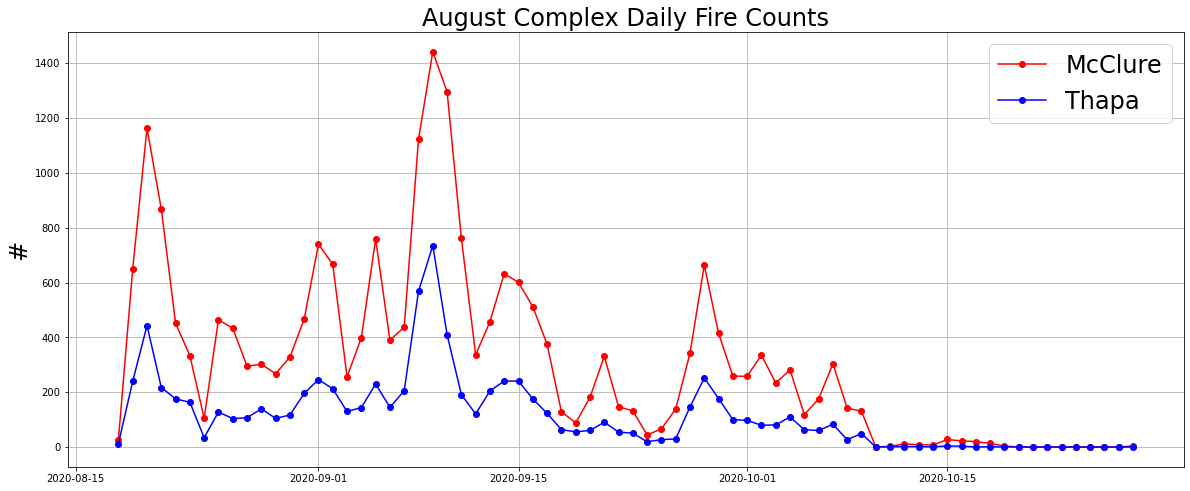

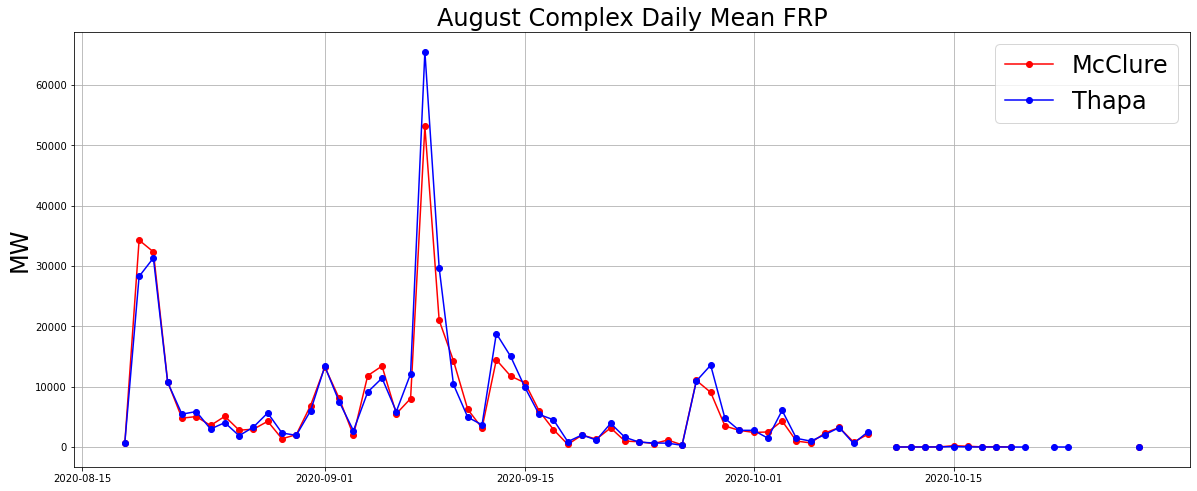

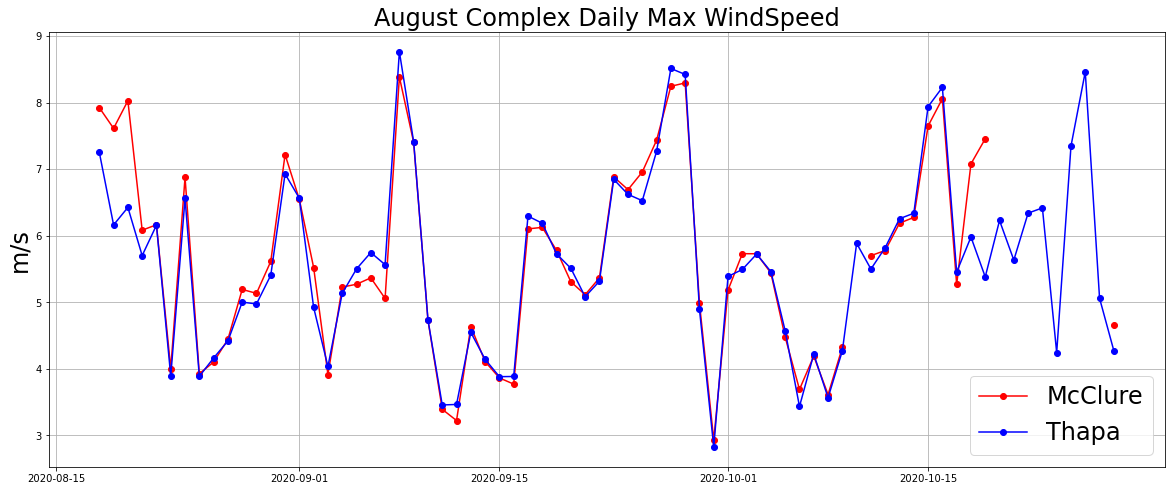

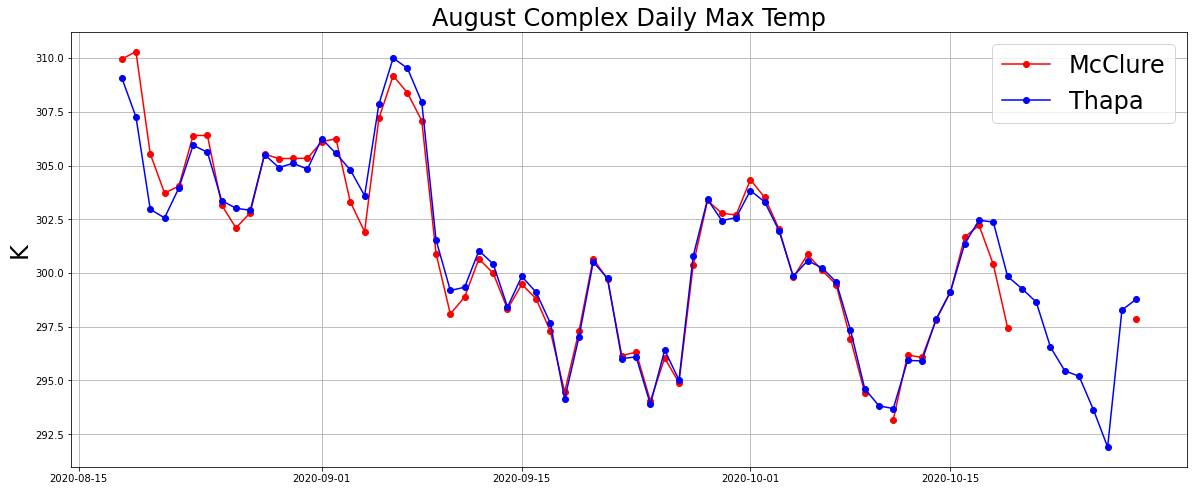

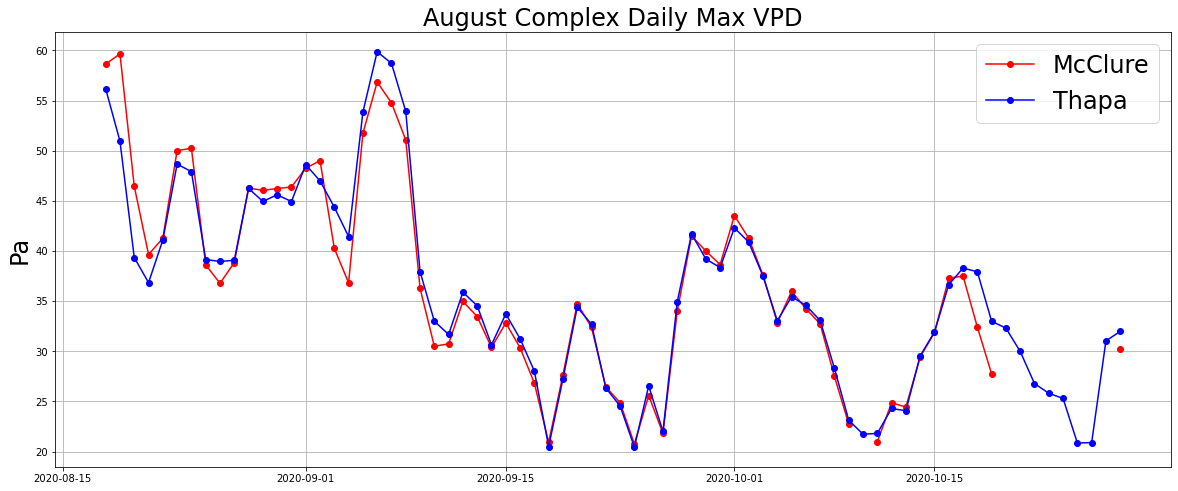

In [42]:
plot_twoline(times, num_points, 'August Complex Daily Fire Counts', ['McClure', 'Thapa'], '#', 0)
plot_twoline(times, frp, 'August Complex Daily Mean FRP', ['McClure', 'Thapa'], 'MW', 0)

plot_twoline(times, wind, 'August Complex Daily Max WindSpeed', ['McClure', 'Thapa'], 'm/s', 0)
plot_twoline(times, temp, 'August Complex Daily Max Temp', ['McClure', 'Thapa'], 'K', 0)
plot_twoline(times, vpd, 'August Complex Daily Max VPD', ['McClure', 'Thapa'], 'Pa', 0)


In [ ]:
plot_twoline(times, np.stack([temp[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([vpd[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([wind[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'Num Pixels'], 1)

plot_twoline(times, np.stack([temp[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'Num Detections'], 1)
plot_twoline(times, np.stack([vpd[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (hPa)', 'Num Detections'], 1)
plot_twoline(times, np.stack([wind[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'Num Detections'], 1)



In [ ]:
#personnel comparison
plot_twoline(times, np.stack([personnel, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([personnel, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([personnel, num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)
plot_twoline(times, np.stack([personnel, num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)

    Unnamed: 0         Day  fuels_thapa  slopes_thapa  aspects_thapa  \
0            0  2020-08-18         16.0          47.0           36.0   
1            1  2020-08-19          7.0          47.0           -1.0   
2            2  2020-08-20          7.0          47.0           -1.0   
3            3  2020-08-21          7.0          47.0          354.0   
4            4  2020-08-22          7.0          47.0          354.0   
..         ...         ...          ...           ...            ...   
67          67  2020-10-24          7.0          36.0           52.0   
68          68  2020-10-25          7.0          36.0           52.0   
69          69  2020-10-26          7.0          36.0           52.0   
70          70  2020-10-27          7.0          36.0           52.0   
71          71  2020-10-28          7.0          36.0          165.0   

    fuels_mcclure  slopes_mcclure  aspects_mcclure  
0            16.0            47.0             57.0  
1            46.0            

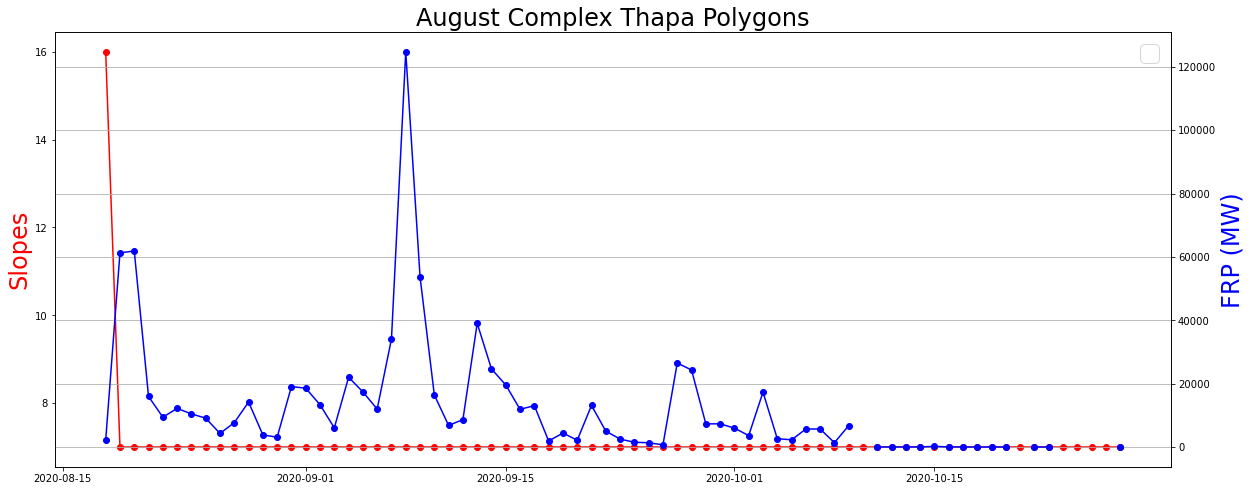

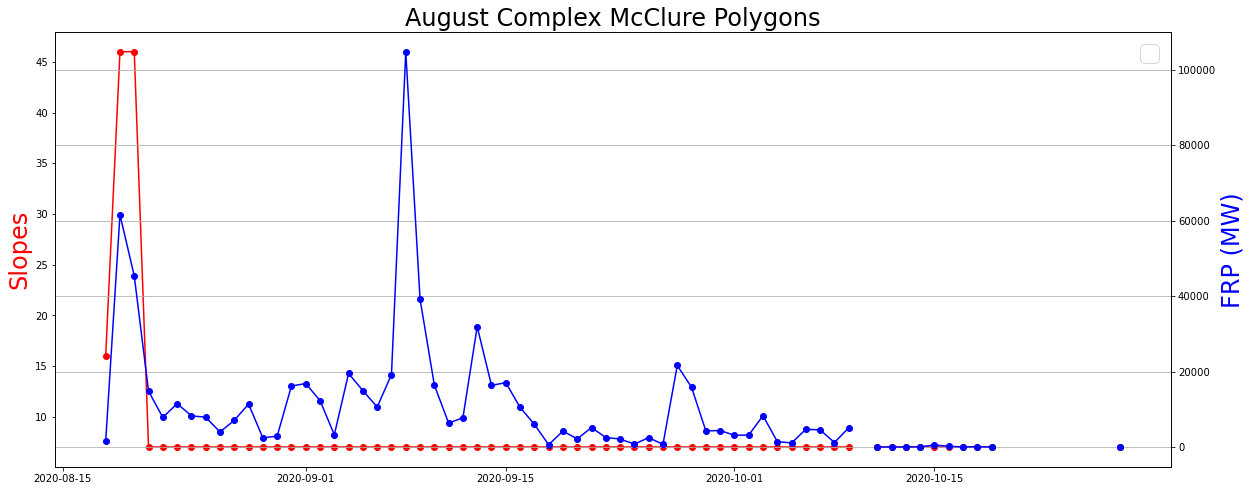

In [72]:
# FCCS comparison
df_fuels = pd.read_csv('Fuels_Info_August_Complex.csv')
print(df_fuels)

plot_twoline(times, np.stack([df_fuels['fuels_thapa'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_fuels['fuels_mcclure'].values, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)

In [ ]:
print(df_gbbepx_thapa['CO'].values.shape)

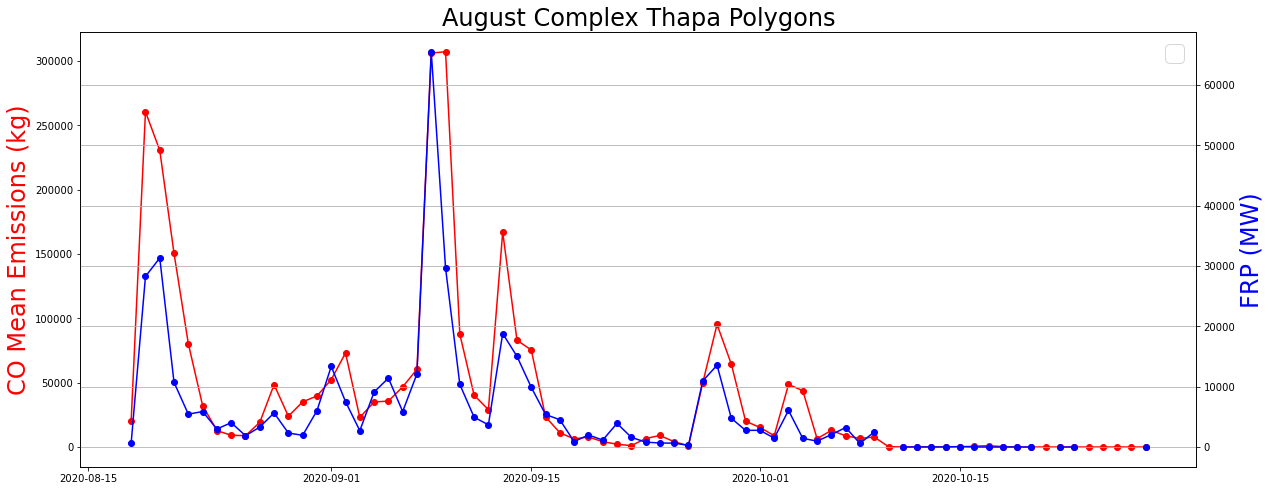

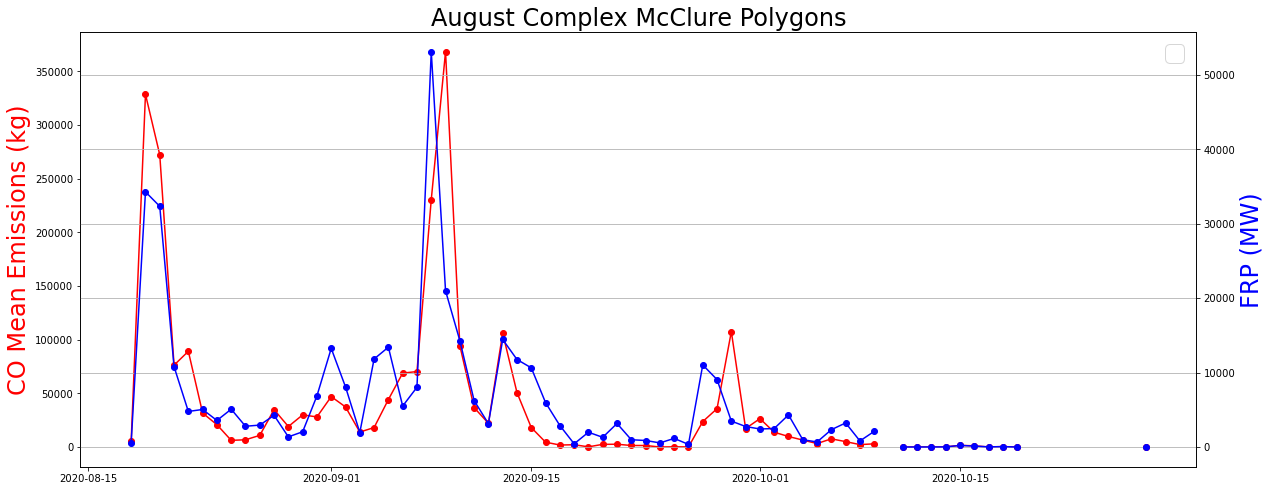

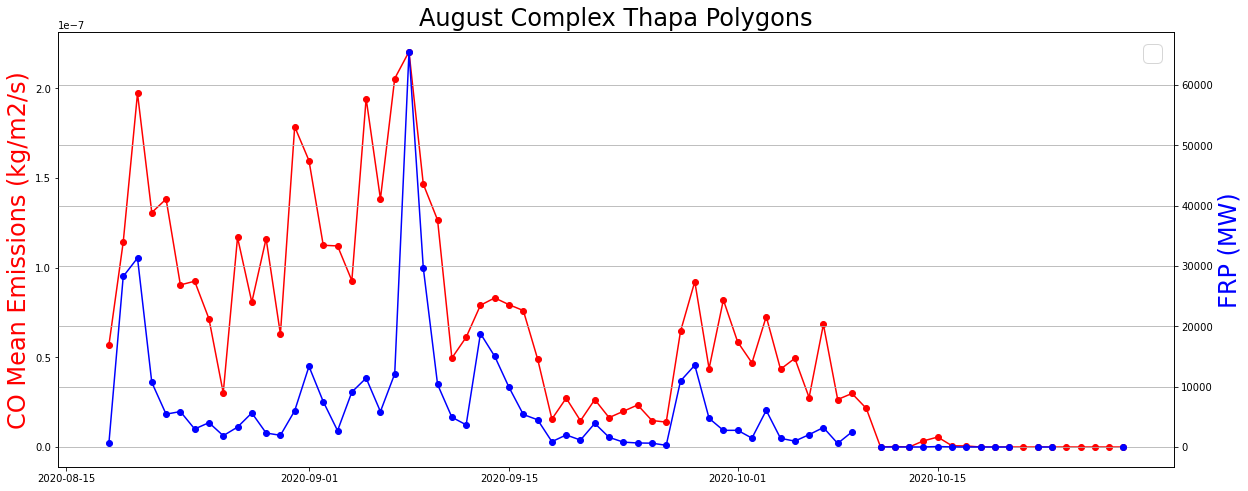

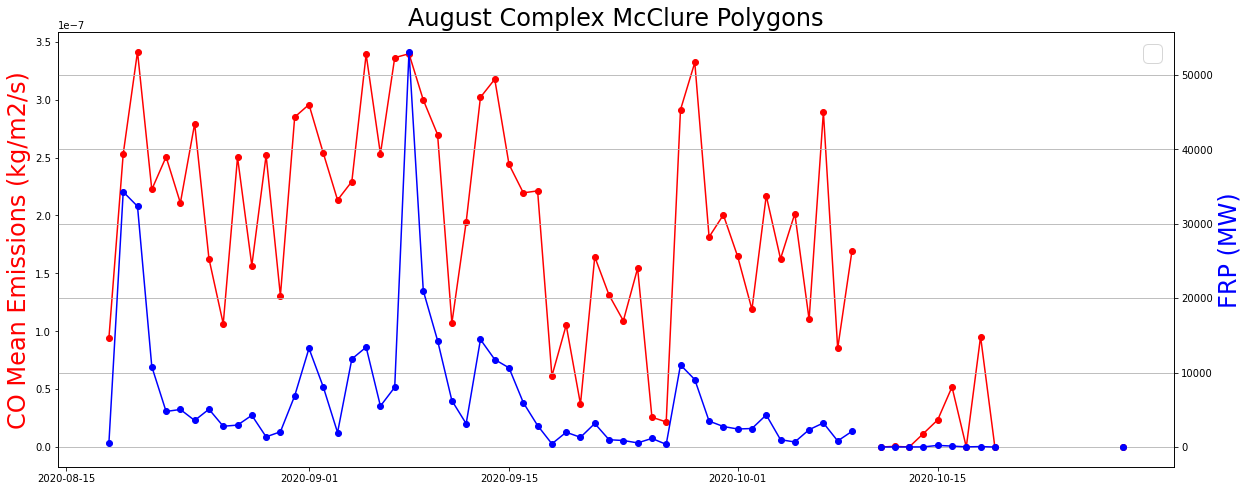

In [34]:
# GBBEPx Comparison
plot_twoline(times, np.stack([df_gbbepx_thapa['CO'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Mean Emissions (kg)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_gbbepx_mcclure['CO'].values, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['CO Mean Emissions (kg)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([carbon_monoxide[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([carbon_monoxide[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)

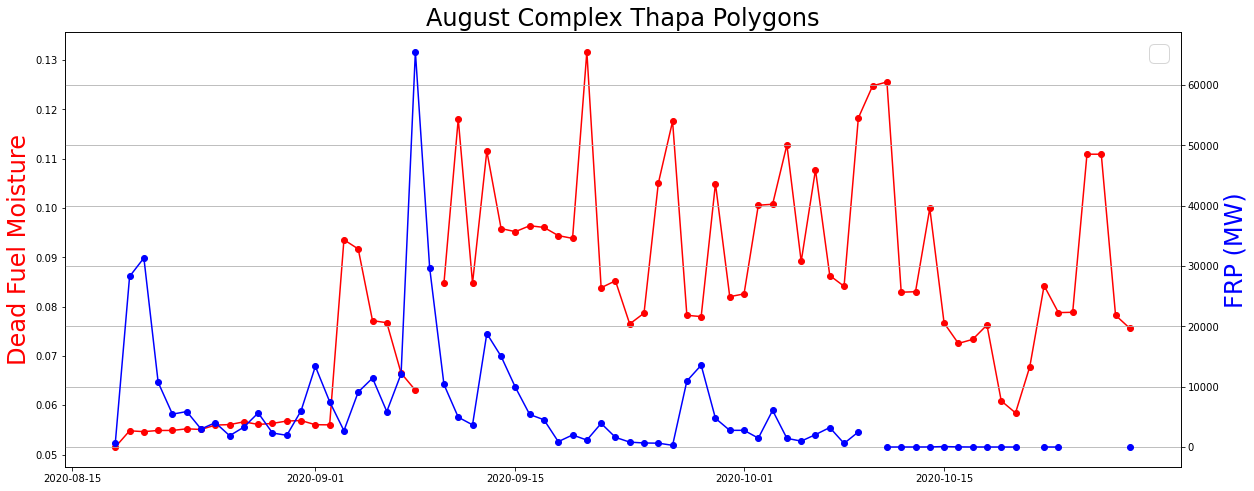

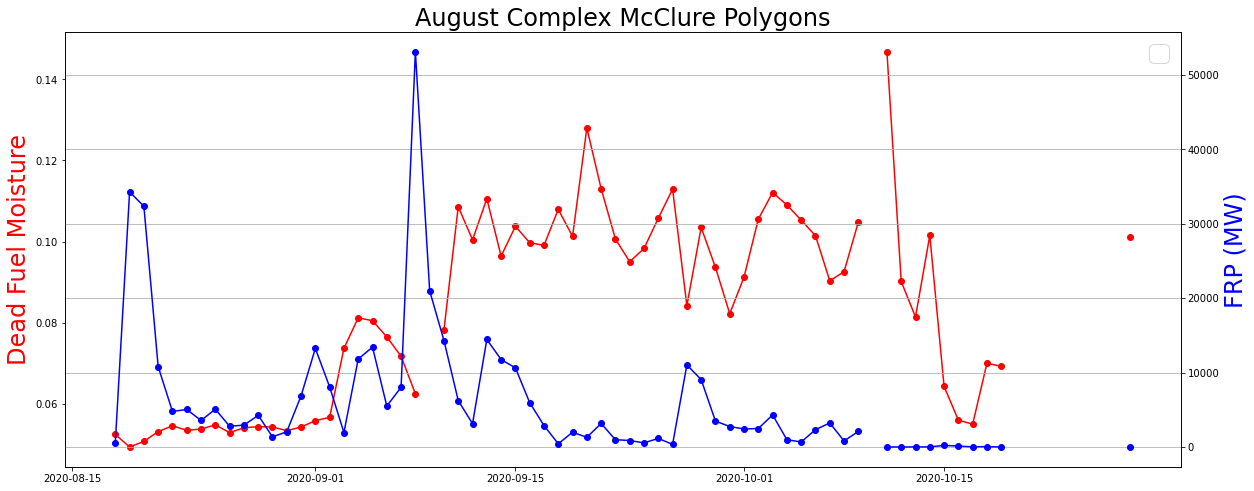

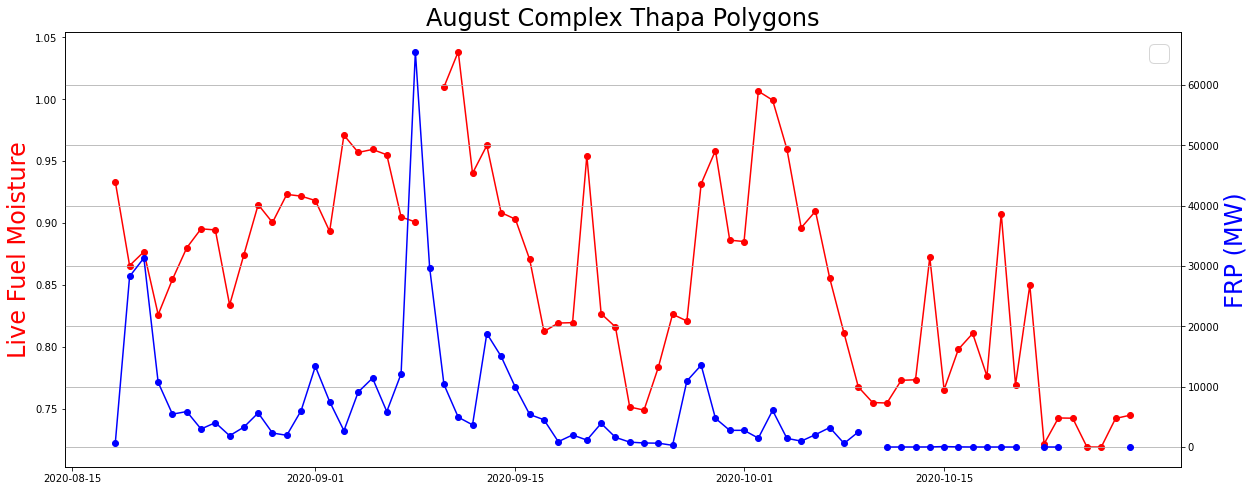

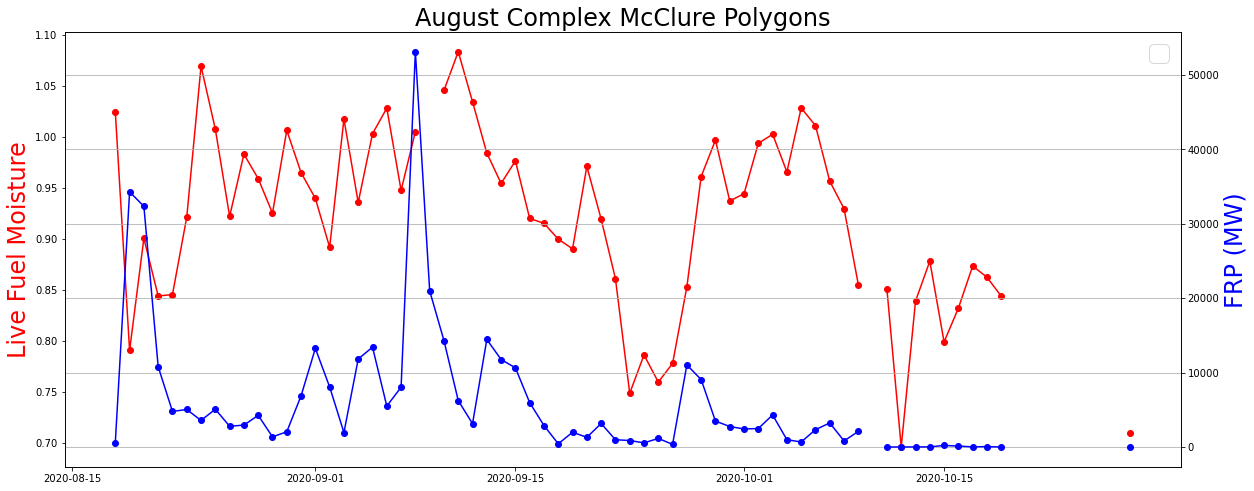

In [65]:
#fuel moisture

plot_twoline(times, np.stack([mdead[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mdead[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([mlive[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mlive[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)

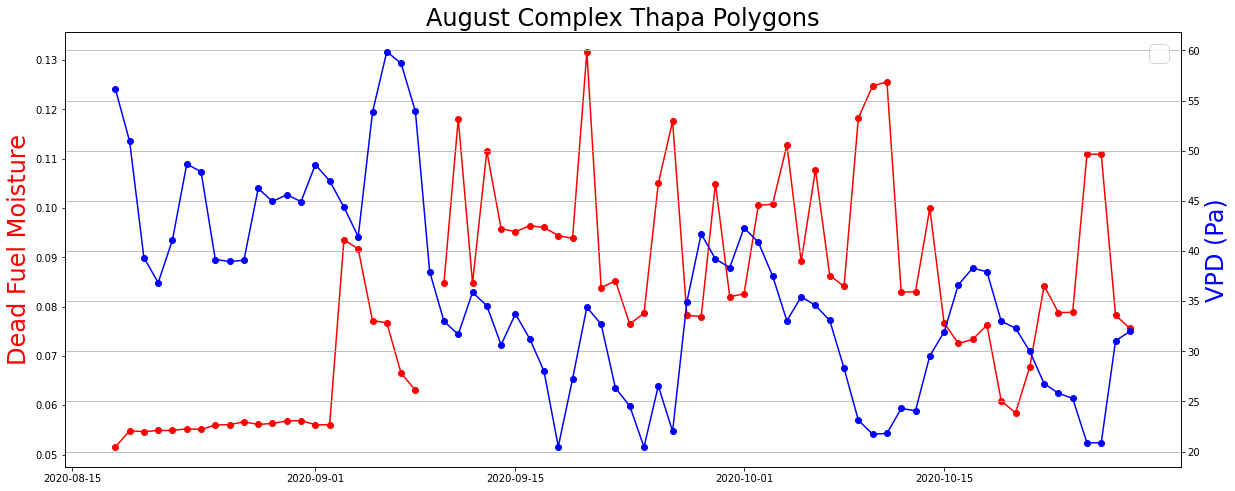

          mdead       VPD
mdead  1.000000 -0.581339
VPD   -0.581339  1.000000


In [138]:
# vpd and fuel moisture
plot_twoline(times, np.stack([mdead[1,:], vpd[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'VPD (Pa)'], 1)
df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd[1,:]})
print(df_test_qfed.corr())

#fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
#plt.scatter(vpd[1,:], mdead[1,:])
#ax.set_xlabel('VPD (Pa)', fontsize=24) 
#ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
#plt.show()


          mdead       VPD
mdead  1.000000 -0.581339
VPD   -0.581339  1.000000


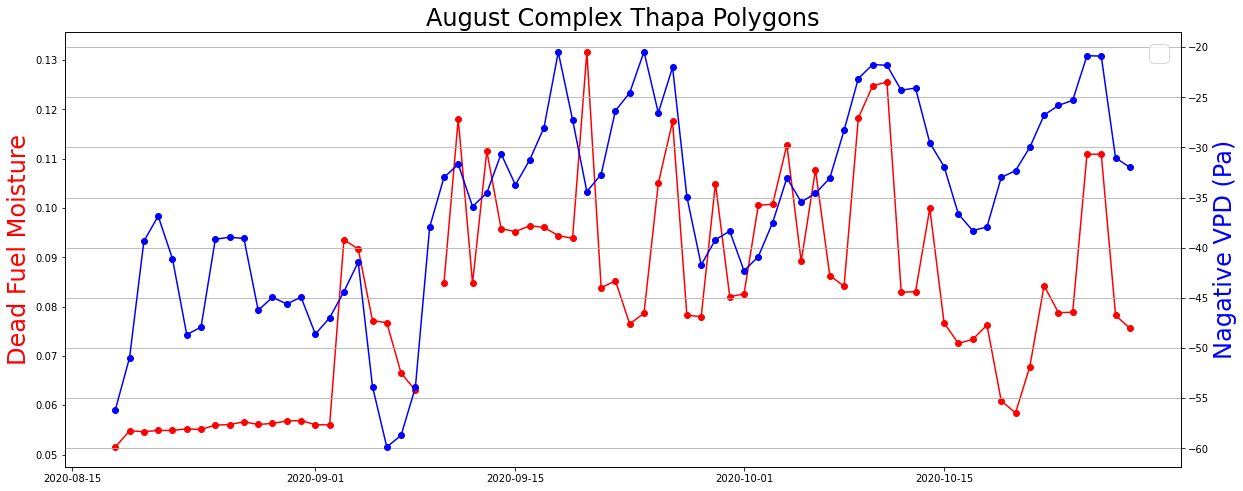

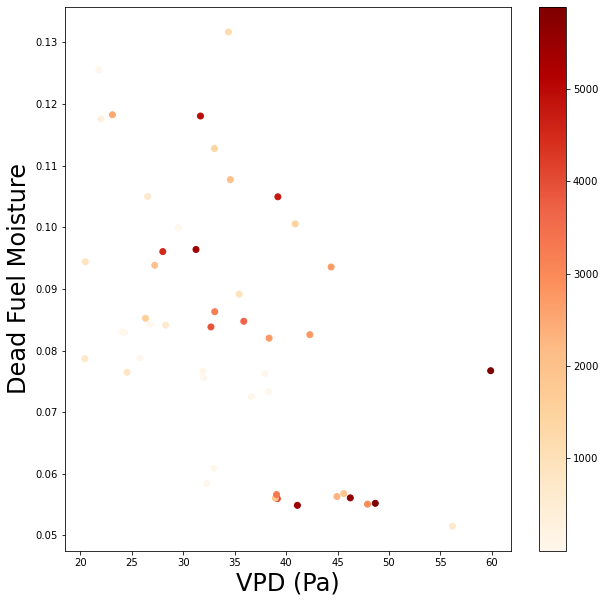

In [167]:
# shifting to deal with when we have nans in the cross correlation

n_shift = 0
vpd_shifted = np.concatenate([np.nan*np.zeros(n_shift), vpd[1,0:len(vpd[1,:])-(n_shift)]])
#print(vpd[1,:], vpd_shifted)
#print(len(vpd[1,:]), len(vpd_shifted))

df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd_shifted})
print(df_test_qfed.corr())

plot_twoline(times, np.stack([mdead[1,:], -vpd_shifted]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'Nagative VPD (Pa)'], 1)


fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(vpd_shifted[np.where(frp[1,:]<6000)],mdead[1,np.where(frp[1,:]<6000)], c=frp[1,np.where(frp[1,:]<6000)], cmap='OrRd')
plt.colorbar()
ax.set_xlabel('VPD (Pa)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

## Time Series plots to check QFED (4/12/2022)

          pmdaily       frp
pmdaily  1.000000  0.648619
frp      0.648619  1.000000


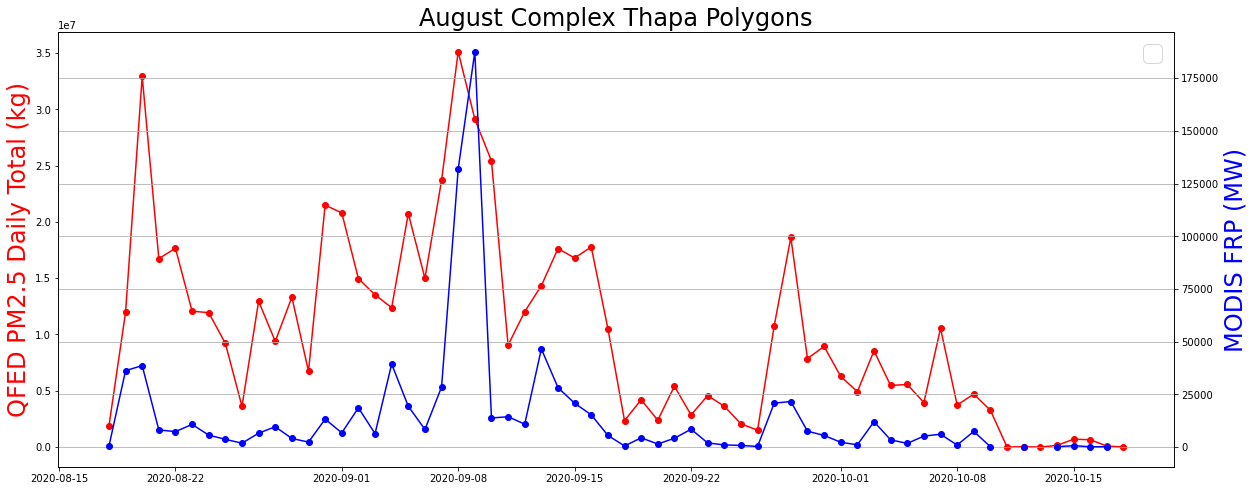

          pmrate       frp
pmrate  1.000000  0.649155
frp     0.649155  1.000000


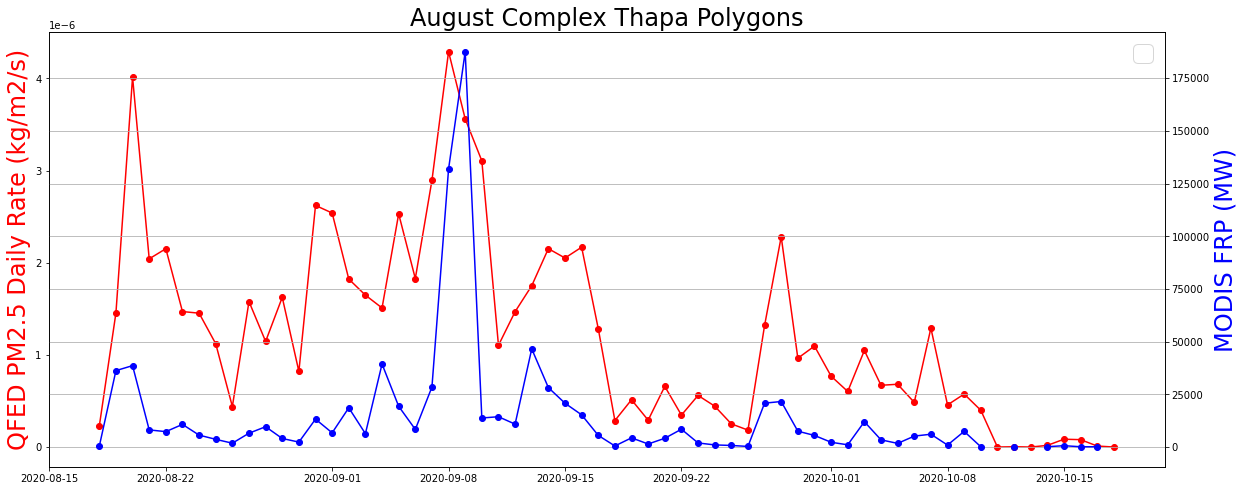

          pmrate       frp
pmrate  1.000000  0.879191
frp     0.879191  1.000000


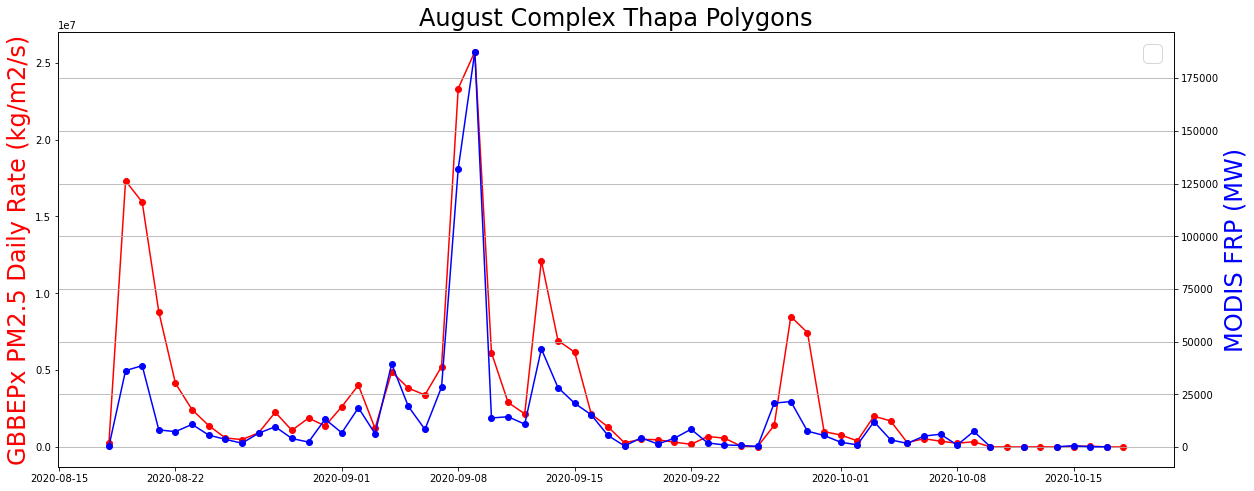

In [32]:
# compare daily qfed rates and totals with GBBEPx
print(pd.DataFrame({'pmdaily':pm25_daily_total[1,:],'frp': frp[1,:] }).corr())
plot_twoline(times, np.stack([pm25_daily_total[1,:], frp[1,:] ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Daily Total (kg)', 'MODIS FRP (MW)'], 1)

print(pd.DataFrame({'pmrate':pm25_daily_rate[1,:],'frp': frp[1,:] }).corr())
plot_twoline(times, np.stack([pm25_daily_rate[1,:], frp[1,:] ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Daily Rate (kg/m2/s)', 'MODIS FRP (MW)'], 1)

print(pd.DataFrame({'pmrate':df_gbbepx_thapa['PM2.5'],'frp': frp[1,:] }).corr())
plot_twoline(times, np.stack([df_gbbepx_thapa['PM2.5'], frp[1,:] ]),\
             'August Complex Thapa Polygons',\
             [], ['GBBEPx PM2.5 Daily Rate (kg/m2/s)', 'MODIS FRP (MW)'], 1)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
                 PM2.5 QFED Rate       cod
PM2.5 QFED Rate         1.000000  0.294267
cod                     0.294267  1.000000


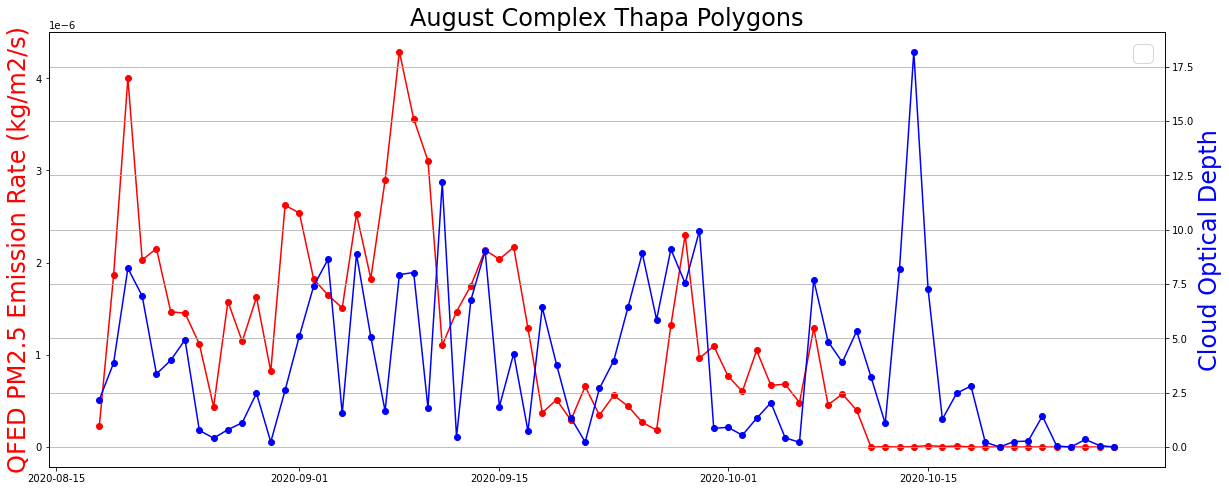

                 PM2.5 QFED Rate  3day Cod
PM2.5 QFED Rate         1.000000  0.481451
3day Cod                0.481451  1.000000


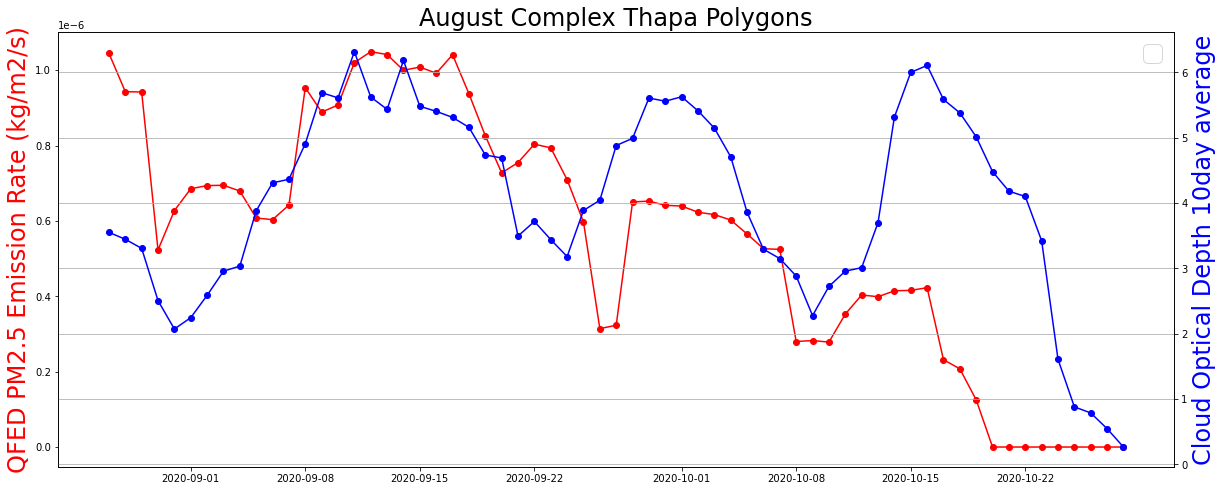

In [72]:
# see if qfed persistence goes with cloud optical depth
print(df_thapa.columns)
print(df_thapa[['PM2.5 QFED Rate', 'cod']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Rate'].values, df_thapa['cod'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth'], 1)

window_size = 10
cod_series = df_thapa['cod']
pm25_series = df_thapa['PM2.5 QFED Rate']
cod_windows = cod_series.rolling(window_size)
pm25_windows = pm25_series.rolling(window_size)

cod_averages=cod_windows.mean()
pm25_std = pm25_windows.std()

df_test = pd.DataFrame({'PM2.5 QFED Rate':pm25_std, '3day Cod':cod_averages})
print(df_test.corr())
plot_twoline(times, np.stack([pm25_std.values, cod_averages.values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth '+str(window_size)+ 'day average'], 1)


## Scatter plots

In [ ]:
#find where personnel and frp ~=nan

nonan_ind = np.where(~np.isnan(personnel)&~np.isnan(frp[1,:])&(frp[1,:]<12000))
print(len(personnel[nonan_ind]))
print(len(frp[1,nonan_ind][0]))
theta = np.polyfit(personnel[nonan_ind], frp[1,nonan_ind][0], 1)
print(theta)
y_line = theta[1] + theta[0] * personnel[nonan_ind]
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(personnel, frp[1,:])
plt.plot(personnel[nonan_ind], y_line, 'r')
plt.text(3500, 80000, 'Maybe a negative slope, but pretty driven by outlier')
plt.title('Personnel vs FRP (Thapa Polygons)', fontsize=24)
ax.set_ylabel('FRP (MW)', fontsize=24) 
ax.set_xlabel('Personnel (#)', fontsize=24) 
plt.show()

          FRP        CO
FRP  1.000000  0.686796
CO   0.686796  1.000000
              FRP            CO
FRP  1.030114e+08  4.076474e-04
CO   4.076474e-04  3.437797e-15


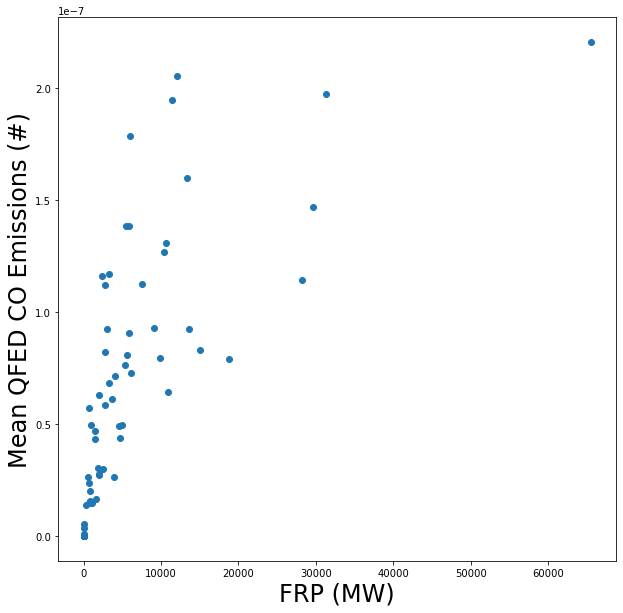

        FRP      CO
FRP  1.0000  0.9092
CO   0.9092  1.0000
              FRP            CO
FRP  1.030114e+08  6.391415e+08
CO   6.391415e+08  4.537286e+09


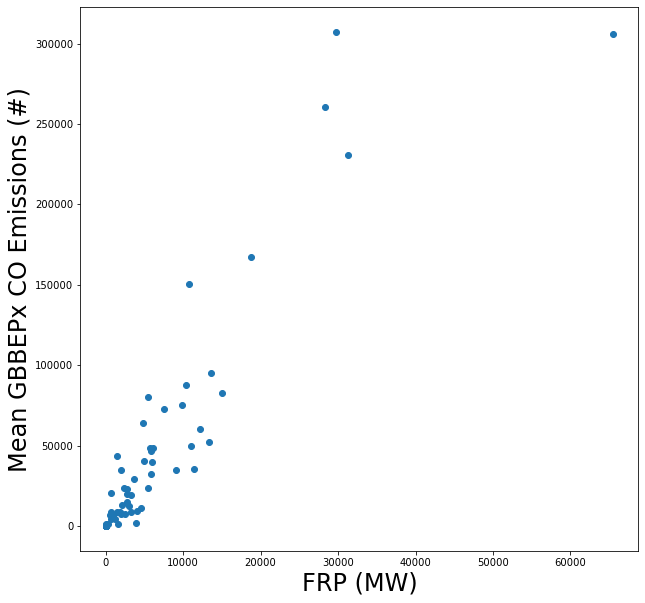

In [35]:
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], carbon_monoxide[1,:])#for the Thapa polygons
df_test_qfed = pd.DataFrame({'FRP':frp[1,:], 'CO':carbon_monoxide[1,:]})
print(df_test_qfed.corr())
print(df_test_qfed.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean QFED CO Emissions (#)', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], df_gbbepx_thapa['CO'].values)#for the Thapa polygons
df_test_gbbepx = pd.DataFrame({'FRP':frp[1,:], 'CO': df_gbbepx_thapa['CO'].values})
print(df_test_gbbepx.corr())
print(df_test_gbbepx.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean GBBEPx CO Emissions (#)', fontsize=24) 
plt.show()

            FRP     mlive
FRP    1.000000  0.258395
mlive  0.258395  1.000000
                FRP       mlive
FRP    1.030114e+08  194.414720
mlive  1.944147e+02    0.006614


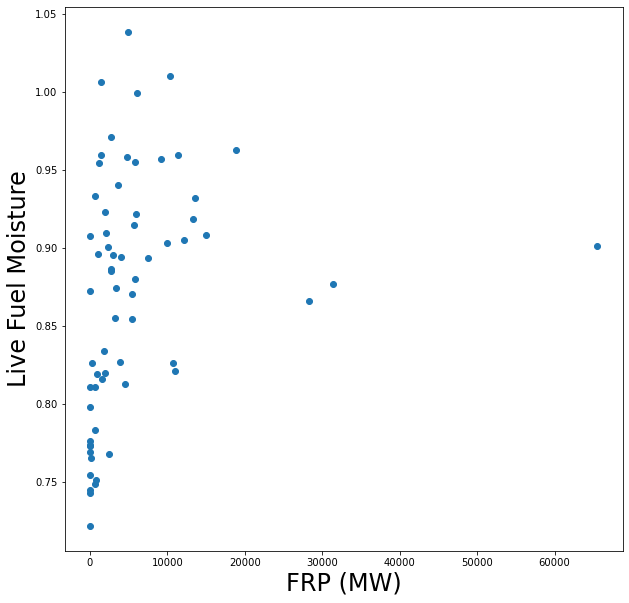

            FRP     mdead
FRP    1.000000 -0.221376
mdead -0.221376  1.000000
                FRP      mdead
FRP    1.030114e+08 -44.880598
mdead -4.488060e+01   0.000446


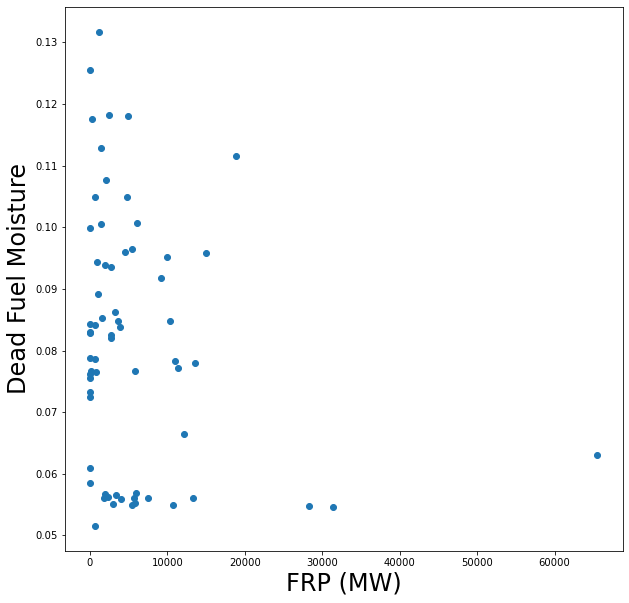

In [63]:
#fuel moisture
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mlive[1,:])#for the Thapa polygons
df_test_live = pd.DataFrame({'FRP':frp[1,:], 'mlive':mlive[1,:]})
print(df_test_live.corr())
print(df_test_live.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Live Fuel Moisture', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mdead[1,:])#for the Thapa polygons
df_test_dead = pd.DataFrame({'FRP':frp[1,:], 'mdead': mdead[1,:]})
print(df_test_dead.corr())
print(df_test_dead.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

In [36]:
from sklearn.metrics import explained_variance_score



In [40]:
nonan_ind_qfed = np.where(~np.isnan(frp[1,:])&~np.isnan( carbon_monoxide[1,:]))
print(explained_variance_score(frp[1,nonan_ind_qfed][0], carbon_monoxide[1,nonan_ind_qfed][0]))

nonan_ind_gbbepx = np.where(~np.isnan(frp[1,:])&~np.isnan( df_gbbepx_thapa['CO'].values))
print(explained_variance_score(frp[1,nonan_ind_gbbepx][0], df_gbbepx_thapa['CO'].values[nonan_ind_gbbepx]))

7.914668920250278e-12
-34.16065426214584


## Do some cross correlations

the ccf command doesn't like nans

In [ ]:
vpd_num_thapa = sm.tsa.stattools.ccf(vpd[1,:], num_points[1,:], adjusted=False)
print(vpd_num_thapa)
print(np.argmax(abs(vpd_num_thapa)))

plt.plot(range(len(vpd_num_thapa)), vpd_num_thapa)
plt.show()

temp_num_thapa = sm.tsa.stattools.ccf(wind[1,:], num_points[1,:], adjusted=False)
print(temp_num_thapa)
print(np.argmax(abs(temp_num_thapa)))
plt.plot(range(len(temp_num_thapa)), temp_num_thapa)
plt.show()

## Correlograms

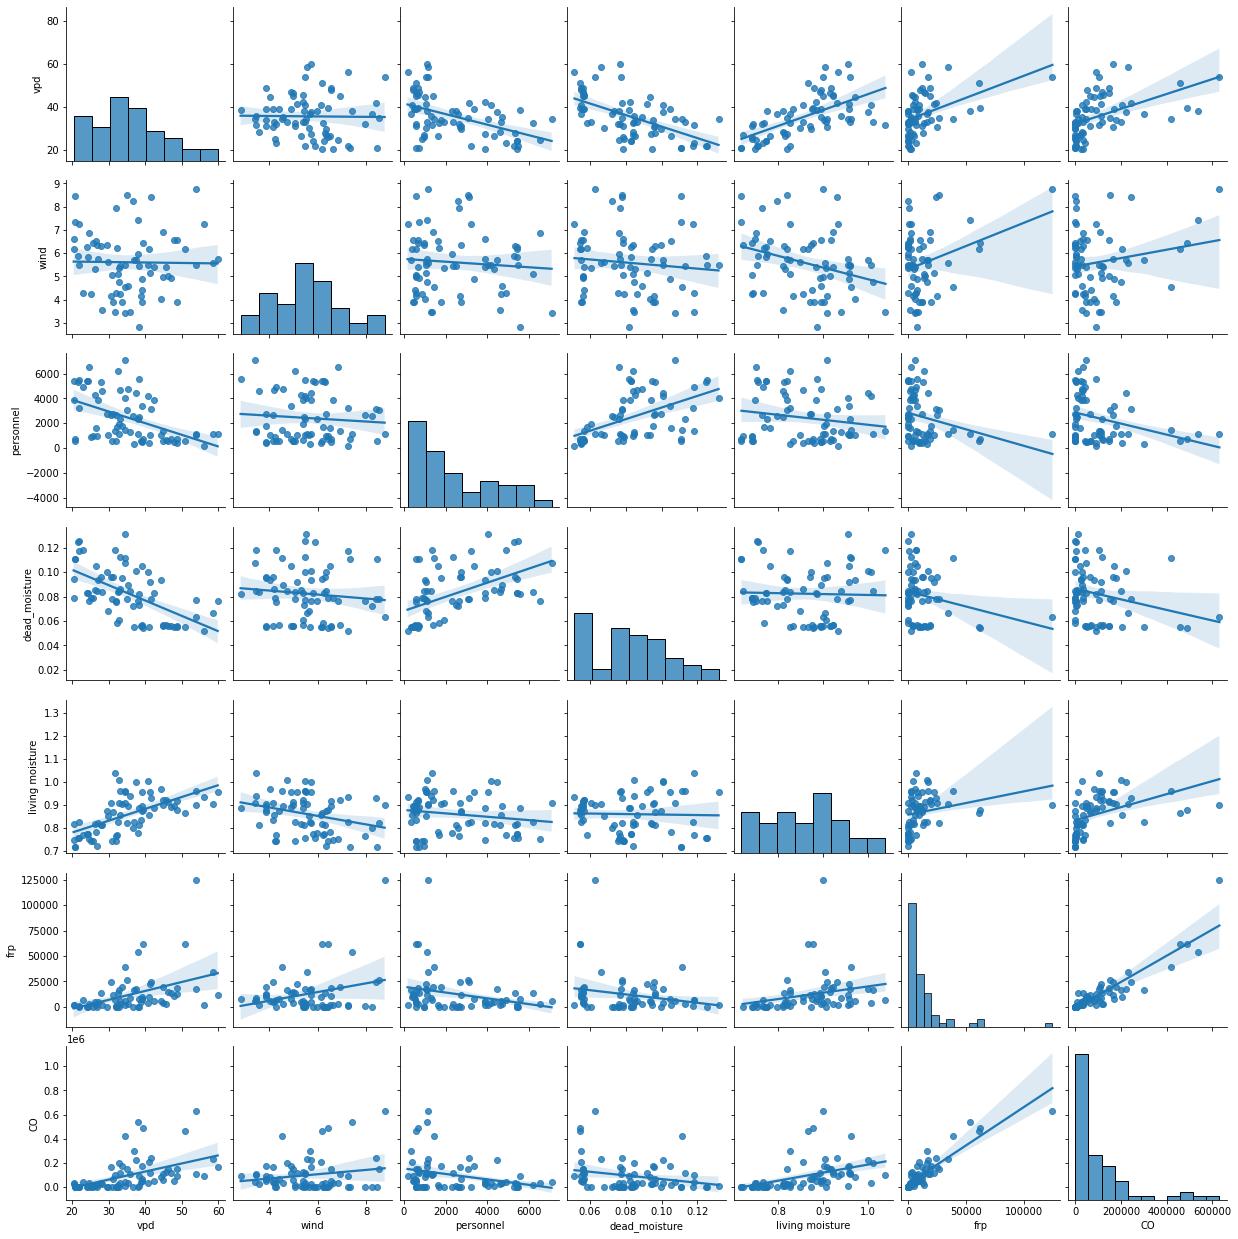

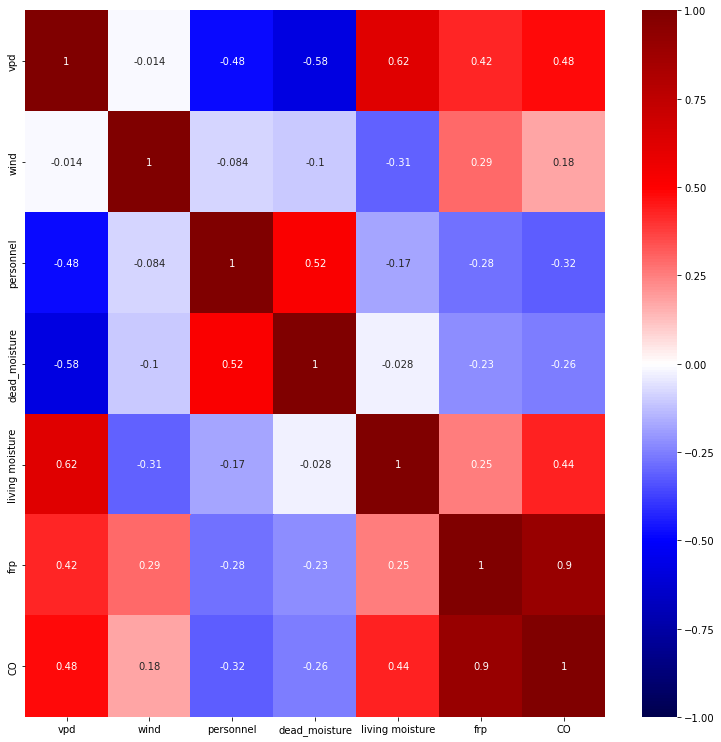

In [80]:
df_thapa = pd.read_csv('AC_Thapa.csv') #load in the data
df_thapa
sns.pairplot(df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.show()

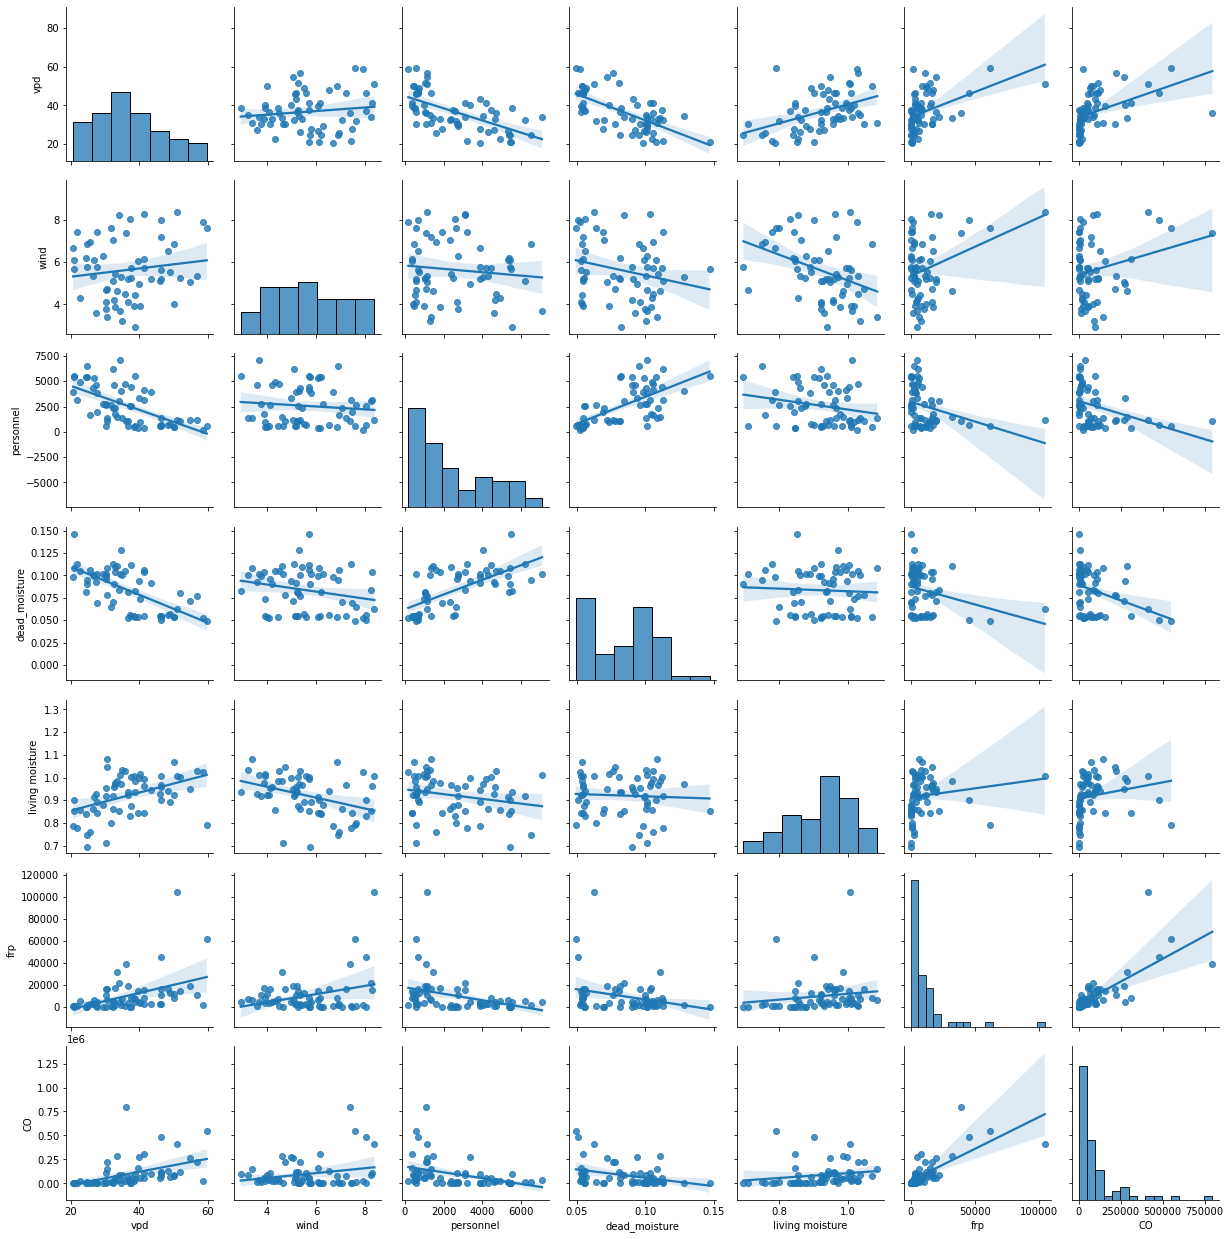

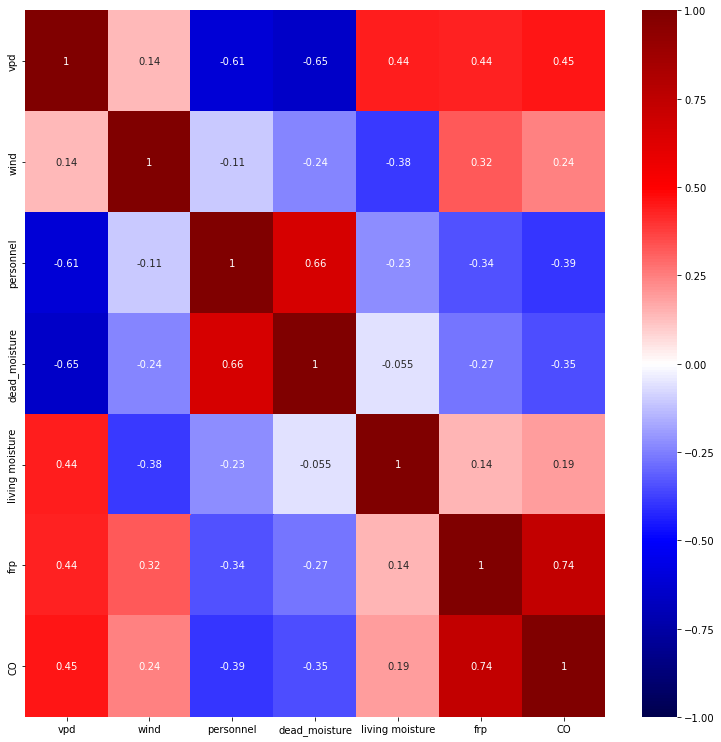

In [81]:
df_mcclure = pd.read_csv('AC_McClure.csv') #load in the data
df_mcclure
sns.pairplot(df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.show()

## Moving Average

72
            FRP     mdead
FRP    1.000000 -0.205906
mdead -0.205906  1.000000


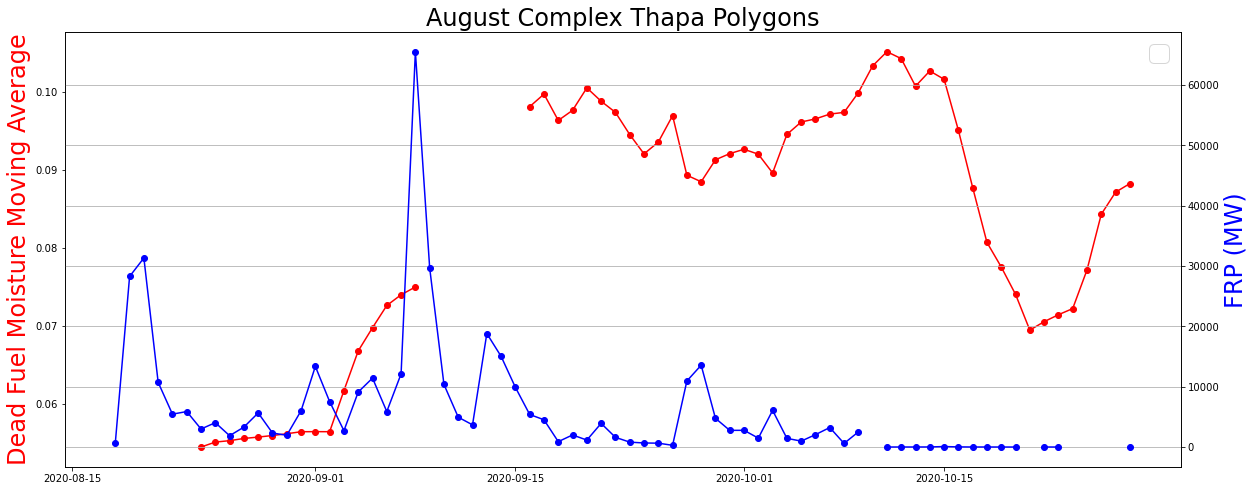

In [91]:
window_size = 7
mdead_series = df_moisture['Dead Thapa']
windows = mdead_series.rolling(window_size)
moving_averages=windows.mean()
moving_averages_list = moving_averages.tolist()
print(len(moving_averages_list))

dead = pd.DataFrame({'FRP':frp[1,:], 'mdead':moving_averages_list})
print(dead.corr())

plot_twoline(times, np.stack([moving_averages_list, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture Moving Average', 'FRP (MW)'], 1)

## Helper Functions

In [10]:
def choose_plot_grid_size(days):
    n_days = len(days)
    sizes = np.linspace(1,16, 16)
    squares = sizes**2
    side = np.amin(np.where(squares>n_days))+1
    nrows = side
    ncols = side
    return nrows, ncols

In [10]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [11]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
# buff_search is the buffer for finding overlaps, =1 for everything except NCAR Fuel = 0.05
#grid type should be 'rectilinear' or 'curvilinear'
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape, grid_type, buff_search):
    overlaps = np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    fire_shape = fire_shape.buffer(0)
    #print(fire_shape.area)
    #buffer again by 1 degree so we can get the lat start and lat stop
    fire_shape_buff = fire_shape.buffer(buff_search)
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape_buff.bounds
    print(w,s,e,n)
    if grid_type =='rectilinear':    
        lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
        lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
        lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
        lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
        #print(lat_start, lat_stop, lon_start, lon_stop)
    elif grid_type=='curvilinear':
        lon_start, lon_stop, lat_start, lat_stop =  bbox2ij(lon, lat, [w, e, s, n])
        
    print(lon_start, lon_stop, lat_start, lat_stop)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop):
        for jj in range(lon_start, lon_stop):
            #print(lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]),\
                                 (lon_corners[ii, jj],lat_corners[ii, jj]),\
                                 (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]),\
                                 (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            #THIS SHOWS THE CELLS WE CHECK FOR OVERLAPS
            #fig = plt.figure(figsize=(15,10))
            #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
            #gpd.GeoSeries(poly_cell).plot(ax=ax)
            #gpd.GeoSeries(fire_shape).plot(ax=ax, color='r', alpha=0.5)
            #plt.xticks()
            #plt.yticks()
            #plt.show()
            overlap_cell = fire_shape.intersection(poly_cell)
            #print(overlap_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps

In [12]:
# this function extracts a feature hourly over the polygon for the day
#IN: feat_grid, the 3d grid of the feature. overlaps: the 2d grid of the overlaps. 3d grid needs time as 1st dimension
#OUT: hourly_vec, the hourly time series of the feature over the day for the polygon

def feature_hourly(feat_grid, overlaps): 
    overlaps_stacked = np.repeat(overlaps[:, :, np.newaxis], 24, axis=2) #stack the 2d overlaps into a 3d grid
    overlaps_swapped = np.swapaxes(np.swapaxes(overlaps_stacked, 0,2), 1,2) #make the same shape as the feature grid

    hourly_grid = np.multiply(overlaps_swapped, feat_grid)
    hourly_vec = np.nansum(np.nansum(hourly_grid, axis=1), axis=1)
    
    return hourly_vec

In [13]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    
        
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()



In [14]:
#finds the most common value of the array (the mode)
#IN the array
#OUT the mode of the array
def find_mode(arr):
    vals,counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return vals[index]


In [15]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

In [16]:
earth_SA = 5e14; #surface area of earth m2


def area_per_grid_cell(lats, lons, dlat, dlon):
    r_earth = 6.371e6; #radius of earth in m
    area_per_box = np.zeros((len(lats), len(lons)));
    for ii in range(len(lons)): #loop over the lons/x positions
        for jj in range(len(lats)): # loop over the lats/y positions
            top_lat = lats[jj]+(dlat/2); #upper bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            bottom_lat = lats[jj]-(dlat/2); # lower bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            box_height = dlat*r_earth*(math.pi/180); # box heights in m, constant because latiude lines are parallel
            top_width = (r_earth*dlon*math.pi*np.cos(math.radians(top_lat)))/180;
            bottom_width = (r_earth*dlon*math.pi*np.cos(math.radians(bottom_lat)))/180;
            area_per_box[jj,ii] = (bottom_width + top_width)*box_height/2; # trapezoid approximation, simplifies to triangles at the poles
    return(area_per_box)


In [17]:
#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(data_cod): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = data_cod.variables['goes_imager_projection'].semi_major_axis
    Rpol = data_cod.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = data_cod.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = data_cod.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = data_cod['x'][:]
    lon_rad_1d = data_cod['y'][:]
    
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
        
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test) 
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg

## Code testing zone



In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    ac_mcclure_daily.loc[[ii],'geometry'].plot(figsize=(7,6))
    plt.show()

In [ ]:
ac_thapa_poly_plot = ac_thapa_poly.reset_index(drop=True)
print(ac_thapa_poly_plot)

for ii in range(len(ac_thapa_poly)):
    print(ii)
    ac_thapa_poly_plot.loc[[ii],'geometry'].plot(figsize=(7,6))
    
    plt.show()

In [ ]:
40.0 -123.125

poly_cell = Polygon([(-123.375,39.75), 
                     (-123.375,40.25), 
                     (-122.875,40.25), 
                     (-122.875, 39.75)])

test = ac_mcclure_daily['geometry'].iloc[5]

ser = gpd.GeoDataFrame({'col1': ['name1', 'name2'],'geometry':[test, poly_cell]})
print(ser)
ser.plot()
plt.show()

In [ ]:
test = ac_mcclure_daily.loc[[5],'geometry']
test_buffer = ac_mcclure_daily.loc[[5],'geometry'].buffer(0)

test.plot()
plt.show()

test_buffer.plot()
plt.show()

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    w,e,s,n = ac_mcclure_daily['geometry'].iloc[ii].bounds

In [ ]:
#get the max temp for the day
print(dat['TLML'][:].shape)
b = np.repeat(overlap_thapa[:, :, np.newaxis], 24, axis=2)
print(b.shape)
b_swapped = np.swapaxes(np.swapaxes(b, 0,2), 1,2)
print(b_swapped.shape)

temp = np.multiply(b_swapped, dat['TLML'][:])
print(temp.shape)

print(np.nansum(np.nansum(temp, axis=1), axis=1)) #gets hourly temp in the polygon

#temp_hourly=np.zeros(24)
#%for i in range(24):
 #   print(i)
 #   temp_hourly[i] = np.nansum(temp[i, :,:])
#temp_hourly

In [ ]:
print(feature_hourly(dat['TLML'][:], overlap_thapa))
print(feature_hourly(dat['TLML'][:], overlap_mcclure))
print(np.where(overlap_mcclure!=0))
print(np.where(overlap_thapa!=0))

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path:
        path = path.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path = path.replace('400', '401')
    dat = nc.Dataset(path)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][12,:,:]
    Q = dat['QLML'][12,:,:]
    P = dat['PS'][12,:,:]
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
    

In [ ]:
ac_thapa_daily.iloc[30:50]
print(num_points)

In [ ]:
type(ac_thapa['Current Day'].iloc[:])
i = str(int(ac_thapa['Current Overpass'].iloc[0]))
print(type(i))
print(i.zfill(4))



In [ ]:
datestrings = [ac_thapa['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa))]
print(datestrings)

print(np.datetime64())

In [ ]:
print(type(ac_mcclure['DateTim'].iloc[0]))

In [ ]:
if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
    overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
    
    poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
    overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])

In [ ]:
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates.iloc[:].strftime("%d-%m-%y")
print(resources_dates.iloc[0].strftime("%Y-%m-%d"))

resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
print(resources_days)

In [ ]:
personnel/np.max(personnel)

In [ ]:
arr = [1,2,2,2,3,3,4]
print(find_mode(arr))

In [ ]:
print(times[np.argmax(frp[1,:])])

In [ ]:
grid_type ='rectiliner'
if grid_type =='rectilinear':
    print('hello')

In [ ]:
path = './WESTUS_qfed2.emis_co.006.20200818.nc4'
dat = nc.Dataset(path)   
lat = dat['lat'][:]
lon = dat['lon'][:]
LAT, LON = np.meshgrid(lat,lon)
print(LON.shape)
#print(per_box.shape)

per_box = area_per_grid_cell(lat, lon, 0.1, 0.1)
#print(area_per_grid_cell(lat, lon, 0.1, 0.1))

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-123.4, -122.6, 39.4, 40.5])
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
plt.contourf(LON,LAT, per_box )
plt.title('GPPEPx OC Daily Emissions Aug 18th')
plt.colorbar()
plt.show()

In [102]:
df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})


,,B
0,B,NaN
1,B,NaN
2,B,NaN
3,B,NaN
4,B,NaN


In [114]:
arr = np.array([1,2,3,4])
print(shift(arr,2,cval=np.nan)) #+2 shifts right 2
print(shift(arr,-2,cval=np.nan)) #+2 shifts right 2



[-9223372036854775808 -9223372036854775808                    1
                    2]
[                   3                    4 -9223372036854775808
 -9223372036854775808]


nan